# A New Charging Station for Düsseldorf

In [3]:
import pandas as pd
import numpy as np

In [193]:
CLIENT_ID = 'put YOUR ID in this string' # your Foursquare ID
CLIENT_SECRET = 'put your CLIENT SECRET in this string' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentials:
CLIENT_ID: put YOUR ID in this string
CLIENT_SECRET:put your CLIENT SECRET in this string


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Let's first get a list of the charging stations for electric vehicles in the city, which can be found in Foursquare. The idea here is to take the city centre as geographical coordinates and then look within a circle of sufficient size for charging stations, so that it all of Düsseldorf is covered.

In [194]:
#source: https://www.laengengrad-breitengrad.de/
duesseldorf_latitude= 51.236987 
duesseldorf_longitude= 6.773456

latitude = duesseldorf_latitude
longitude= duesseldorf_longitude
# a quick check on openstreetmap.org reveals that the following radius
# should cover all of Duesseldorf
radius = 8700
# there should not be more than 100 charging stations in Duesseldorf
LIMIT = 100
chargingstation_fsid='5032872391d4c4b30a586d64'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&intent=browse&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, chargingstation_fsid)
url

'https://api.foursquare.com/v2/venues/search?client_id=put YOUR ID in this string&client_secret=put your CLIENT SECRET in this string&ll=51.236987,6.773456&v=20180605&radius=8700&limit=100&intent=browse&categoryId=5032872391d4c4b30a586d64'

#### The above URL only is a proper URL for the Foursquare API if you have put a valid Foursquare ID and Foursquare secret into the second code cell in this notebook. The code below won't run properly otherwise.

In [7]:
results_withbrowseandsearch = requests.get(url).json()
results_withbrowseandsearch

{'meta': {'code': 200, 'requestId': '5ec7f71eb1cac0001b55a22c'},
 'response': {'venues': [{'id': '52ed20ad498e2e54e00ecd9e',
    'name': 'Ladestation E-mobil NRW',
    'location': {'address': 'Europaplatz 1',
     'crossStreet': 'P2',
     'lat': 51.264739,
     'lng': 6.734488,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.264739,
       'lng': 6.734488}],
     'distance': 4112,
     'cc': 'DE',
     'city': 'Düsseldorf',
     'state': 'Nordrhein-Westfalen',
     'country': 'Deutschland',
     'formattedAddress': ['Europaplatz 1 (P2)', 'Düsseldorf', 'Deutschland']},
    'categories': [{'id': '5032872391d4c4b30a586d64',
      'name': 'EV Charging Station',
      'pluralName': 'EV Charging Stations',
      'shortName': 'EV Charging',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/automotive_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1590163334',
    'hasPerk': False},
   {'id': '54a322af498ee5447093a998',
    'name'

In [8]:
type(results_withbrowseandsearch)

dict

In [9]:
locationresults_df=pd.DataFrame.from_dict(results_withbrowseandsearch['response']['venues'])

In [10]:
locationresults_df

categories  hasPerk  \
0  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
1  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
2  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
3  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
4  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   

                         id  \
0  52ed20ad498e2e54e00ecd9e   
1  54a322af498ee5447093a998   
2  59a2d2ef35d3fc3e2ef955a7   
3  5938016ea6ec982d008f529d   
4  580b35c138fa00cd45c88331   

                                            location  \
0  {'address': 'Europaplatz 1', 'crossStreet': 'P...   
1  {'lat': 51.22728034729124, 'lng': 6.7759461519...   
2  {'lat': 51.205047, 'lng': 6.68897, 'labeledLat...   
3  {'address': 'Am Albertussee', 'lat': 51.2372, ...   
4  {'address': 'Höher Weg 100', 'lat': 51.222622,...   

                             name    referralId  
0         Ladestation E-mobil NRW  v-1590163334  
1             Parkhaus Kunsthalle  v-1590163334  
2                Innogy Ladesäule  v-1590163334  
3                      Stromtanke  v-1590163334  
4  Ladesäule Stadwerke Düsseldorf  v-1590163334

The aim now is to get a dataframe with four columns: name, latitude, longitude and city district.

In [11]:
columnnames=['Name','Latitude','Longitude','City District']
indexlist=[0,1,2,3,4]

In [12]:
chargingstations_df = pd.DataFrame(index=indexlist, columns=columnnames)

In [13]:
for i in range(5):
    chargingstations_df.iloc[i]['Name']=locationresults_df['name'][i]
    chargingstations_df.iloc[i]['Latitude']=locationresults_df['location'][i]['lat']
    chargingstations_df.iloc[i]['Longitude']=locationresults_df['location'][i]['lng']

In [14]:
chargingstations_df

Name Latitude Longitude City District
0         Ladestation E-mobil NRW  51.2647   6.73449           NaN
1             Parkhaus Kunsthalle  51.2273   6.77595           NaN
2                Innogy Ladesäule   51.205   6.68897           NaN
3                      Stromtanke  51.2372   6.72549           NaN
4  Ladesäule Stadwerke Düsseldorf  51.2226   6.81245           NaN

One of the stations mentioned is actually in Neuss (which is a neighboring city of Duesseldorf) and will therefore be dropped from the dataframe.

In [15]:
chargingstations_df=chargingstations_df.drop([2])

In [16]:
chargingstations_df

Name Latitude Longitude City District
0         Ladestation E-mobil NRW  51.2647   6.73449           NaN
1             Parkhaus Kunsthalle  51.2273   6.77595           NaN
3                      Stromtanke  51.2372   6.72549           NaN
4  Ladesäule Stadwerke Düsseldorf  51.2226   6.81245           NaN

## Checking the data for completeness and accuracy

After looking for vehicle charging stations with Nominatim on openstreetmap (nominatim.openstreetmap.org), I found more charging stations by looking for the properties amenity=charging station and motorcar=yes. Therefore, the data found on foursquare is incomplete and has to be amended.

It is possible that there are even more charging stations which are for electrical vehicles, but not expressly marked as such, but without further information/investigation, it is difficult to determine whether these charging stations are for bicycles or for electrical cars. If this was a project that an actual decision of a company depended on, one would naturally have to do more reasearch at this point.

In the following, we shall limit ourselves to the stations which are clearly marked for electrical vehicles (i.e. cars) and manually enter the data for the additional stations marked as such.

In [17]:
chargingstations_df=chargingstations_df.append({'Name':'Stadtwerke Düsseldorf','Latitude':51.276635,'Longitude':6.7903395},ignore_index=True)

In [18]:
chargingstations_df

Name Latitude Longitude City District
0         Ladestation E-mobil NRW  51.2647   6.73449           NaN
1             Parkhaus Kunsthalle  51.2273   6.77595           NaN
2                      Stromtanke  51.2372   6.72549           NaN
3  Ladesäule Stadwerke Düsseldorf  51.2226   6.81245           NaN
4           Stadtwerke Düsseldorf  51.2766   6.79034           NaN

In [19]:
chargingstations_df=chargingstations_df.append({'Name':'Stadtwerke Düsseldorf','Latitude':51.2180413,'Longitude':6.7823688},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'EON','Latitude':51.2353848,'Longitude':6.774657},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'Mennekes','Latitude':51.2211178,'Longitude':6.82248},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'DB Energie GmbH','Latitude':51.2210909,'Longitude':6.7935432},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'Stadtwerke Düsseldorf','Latitude':51.2390381,'Longitude':6.7803173},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'Parsevalstr','Latitude':51.2787614,'Longitude':6.7857501},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'Stadtwerke Düsseldorf','Latitude':51.2454296,'Longitude':6.7694346},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'Aldi Süd','Latitude':51.2627009,'Longitude':6.7808851},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'Stadtwerke Düsseldorf','Latitude':51.213918,'Longitude':6.7770302},ignore_index=True)
chargingstations_df=chargingstations_df.append({'Name':'Stadtwerke Düsseldorf','Latitude':51.193844,'Longitude':6.8129154},ignore_index=True)

In [20]:
chargingstations_df

Name Latitude Longitude City District
0          Ladestation E-mobil NRW  51.2647   6.73449           NaN
1              Parkhaus Kunsthalle  51.2273   6.77595           NaN
2                       Stromtanke  51.2372   6.72549           NaN
3   Ladesäule Stadwerke Düsseldorf  51.2226   6.81245           NaN
4            Stadtwerke Düsseldorf  51.2766   6.79034           NaN
5            Stadtwerke Düsseldorf   51.218   6.78237           NaN
6                              EON  51.2354   6.77466           NaN
7                         Mennekes  51.2211   6.82248           NaN
8                  DB Energie GmbH  51.2211   6.79354           NaN
9            Stadtwerke Düsseldorf   51.239   6.78032           NaN
10                     Parsevalstr  51.2788   6.78575           NaN
11           Stadtwerke Düsseldorf  51.2454   6.76943           NaN
12                        Aldi Süd  51.2627   6.78089           NaN
13           Stadtwerke Düsseldorf  51.2139   6.77703           NaN
14           Stadtwerke Düsseldorf  51.1938   6.81292           NaN

The dataframe has been filled. Still missing is the assignment of the city district.

Let's visualize the positions of the charging stations.

In [21]:
#creating a map of Düsseldorf with Folium
duesseldorf_map= folium.Map(location=[duesseldorf_latitude, duesseldorf_longitude],zoom_start=12)

In [22]:
duesseldorf_map

In [23]:
#creating a feature group for the existing EV charging stations from the Foursquare data.
ev_stations= folium.map.FeatureGroup()

In [24]:
type(ev_stations)

folium.map.FeatureGroup

In [25]:
chargingstations_df

Name Latitude Longitude City District
0          Ladestation E-mobil NRW  51.2647   6.73449           NaN
1              Parkhaus Kunsthalle  51.2273   6.77595           NaN
2                       Stromtanke  51.2372   6.72549           NaN
3   Ladesäule Stadwerke Düsseldorf  51.2226   6.81245           NaN
4            Stadtwerke Düsseldorf  51.2766   6.79034           NaN
5            Stadtwerke Düsseldorf   51.218   6.78237           NaN
6                              EON  51.2354   6.77466           NaN
7                         Mennekes  51.2211   6.82248           NaN
8                  DB Energie GmbH  51.2211   6.79354           NaN
9            Stadtwerke Düsseldorf   51.239   6.78032           NaN
10                     Parsevalstr  51.2788   6.78575           NaN
11           Stadtwerke Düsseldorf  51.2454   6.76943           NaN
12                        Aldi Süd  51.2627   6.78089           NaN
13           Stadtwerke Düsseldorf  51.2139   6.77703           NaN
14           Stadtwerke Düsseldorf  51.1938   6.81292           NaN

In [26]:
for i in range(len(chargingstations_df)):
    ev_stations.add_child(folium.CircleMarker([chargingstations_df.Latitude[i], chargingstations_df.Longitude[i]], radius=5, color='red', fill_color='Red'))

In [27]:
ev_stations

In [28]:
duesseldorf_map.add_child(ev_stations)

In [29]:
duesseldorf_map.save(outfile='results/ev-stations-duesseldorf.html')

In the above map, red circles indicate charging stations for electrical vehicles.

## Importing District Boundaries

The next step is to import the city district boundaries. The files are of the geojson type and are approximate polygons (which can be a bit bigger than the actual district boundaries).

In [30]:
import geojson
from geojson import MultiPolygon

In [31]:
columnnames2=['City District','Polygon','Population Density [1/km^2]']
indexlist2=list(range(0,50))
districts_df = pd.DataFrame(index=indexlist2, columns=columnnames2)

In [32]:
districts_df

City District Polygon Population Density [1/km^2]
0            NaN     NaN                         NaN
1            NaN     NaN                         NaN
2            NaN     NaN                         NaN
3            NaN     NaN                         NaN
4            NaN     NaN                         NaN
5            NaN     NaN                         NaN
6            NaN     NaN                         NaN
7            NaN     NaN                         NaN
8            NaN     NaN                         NaN
9            NaN     NaN                         NaN
10           NaN     NaN                         NaN
11           NaN     NaN                         NaN
12           NaN     NaN                         NaN
13           NaN     NaN                         NaN
14           NaN     NaN                         NaN
15           NaN     NaN                         NaN
16           NaN     NaN                         NaN
17           NaN     NaN                         NaN
18           NaN     NaN                         NaN
19           NaN     NaN                         NaN
20           NaN     NaN                         NaN
21           NaN     NaN                         NaN
22           NaN     NaN                         NaN
23           NaN     NaN                         NaN
24           NaN     NaN                         NaN
25           NaN     NaN                         NaN
26           NaN     NaN                         NaN
27           NaN     NaN                         NaN
28           NaN     NaN                         NaN
29           NaN     NaN                         NaN
30           NaN     NaN                         NaN
31           NaN     NaN                         NaN
32           NaN     NaN                         NaN
33           NaN     NaN                         NaN
34           NaN     NaN                         NaN
35           NaN     NaN                         NaN
36           NaN     NaN                         NaN
37           NaN     NaN                         NaN
38           NaN     NaN                         NaN
39           NaN     NaN                         NaN
40           NaN     NaN                         NaN
41           NaN     NaN                         NaN
42           NaN     NaN                         NaN
43           NaN     NaN                         NaN
44           NaN     NaN                         NaN
45           NaN     NaN                         NaN
46           NaN     NaN                         NaN
47           NaN     NaN                         NaN
48           NaN     NaN                         NaN
49           NaN     NaN                         NaN

In [33]:
filepath='stadtteilgrenzen'

In [34]:
import os

In [35]:
polygoncontents= []

In [36]:
entrylist=[]
k=0
for entry in os.scandir(filepath): 
    if entry.name.endswith('.geojson'):
        entrylist.append(entry)
        useless_variable=open(entry)
        inbetween_variable=str(useless_variable.read())
        polygoncontents.append(geojson.loads(inbetween_variable))
        print(k,entry.path)
        k=k+1
    else:
        print('has different filename ending: ',entry.path)

0 stadtteilgrenzen/hafen.geojson
1 stadtteilgrenzen/ludenberg.geojson
2 stadtteilgrenzen/carlstadt.geojson
3 stadtteilgrenzen/holthausen.geojson
has different filename ending:  stadtteilgrenzen/hassels.geojson~
4 stadtteilgrenzen/itter.geojson
5 stadtteilgrenzen/rath.geojson
6 stadtteilgrenzen/derendorf.geojson
7 stadtteilgrenzen/moersenbroich.geojson
8 stadtteilgrenzen/niederkassel.geojson
9 stadtteilgrenzen/hassels.geojson
10 stadtteilgrenzen/loerick.geojson
11 stadtteilgrenzen/altstadt.geojson
12 stadtteilgrenzen/wersten.geojson
13 stadtteilgrenzen/urdenbach.geojson
14 stadtteilgrenzen/hubbelrath.geojson
15 stadtteilgrenzen/wittlaer.geojson
16 stadtteilgrenzen/lichtenbroich.geojson
17 stadtteilgrenzen/kaiserswerth.geojson
18 stadtteilgrenzen/himmelgeist.geojson
19 stadtteilgrenzen/eller.geojson
20 stadtteilgrenzen/stadtmitte.geojson
21 stadtteilgrenzen/volmerswerth.geojson
22 stadtteilgrenzen/vennhausen.geojson
23 stadtteilgrenzen/gerresheim.geojson
24 stadtteilgrenzen/flehe.geojson

The variable 'polygoncontents' contains all the polygon geometries of the individual districts. One example follows:

In [37]:
type(polygoncontents[0])

geojson.feature.FeatureCollection

In [38]:
polygoncontents[0]

{"features": [{"geometry": {"coordinates": [[6.730208, 51.208949], [6.729931, 51.209485], [6.726477, 51.215022], [6.723154, 51.220264], [6.722751, 51.220983], [6.722469, 51.221712], [6.722338, 51.222355], [6.722257, 51.222994], [6.722378, 51.223841], [6.722638, 51.224506], [6.723008, 51.225243], [6.72352, 51.225931], [6.724229, 51.226628], [6.72503, 51.227246], [6.725838, 51.227716], [6.72672, 51.22815], [6.727863, 51.228574], [6.729118, 51.228903], [6.730159, 51.229101], [6.731172, 51.229241], [6.732595, 51.229271], [6.73461, 51.229142], [6.736375, 51.228765], [6.738956, 51.227885], [6.741033, 51.227058], [6.743009, 51.226186], [6.744626, 51.225379], [6.746792, 51.224205], [6.748771, 51.222946], [6.75014, 51.222003], [6.750986, 51.221486], [6.751841, 51.22099], [6.752923, 51.220585], [6.754042, 51.220241], [6.75506, 51.220036], [6.756112, 51.219889], [6.757373, 51.219809], [6.75866, 51.219852], [6.759929, 51.219991], [6.761157, 51.220217], [6.762587, 51.220664], [6.763487, 51.221052],

In [39]:
districts_df

City District Polygon Population Density [1/km^2]
0            NaN     NaN                         NaN
1            NaN     NaN                         NaN
2            NaN     NaN                         NaN
3            NaN     NaN                         NaN
4            NaN     NaN                         NaN
5            NaN     NaN                         NaN
6            NaN     NaN                         NaN
7            NaN     NaN                         NaN
8            NaN     NaN                         NaN
9            NaN     NaN                         NaN
10           NaN     NaN                         NaN
11           NaN     NaN                         NaN
12           NaN     NaN                         NaN
13           NaN     NaN                         NaN
14           NaN     NaN                         NaN
15           NaN     NaN                         NaN
16           NaN     NaN                         NaN
17           NaN     NaN                         NaN
18           NaN     NaN                         NaN
19           NaN     NaN                         NaN
20           NaN     NaN                         NaN
21           NaN     NaN                         NaN
22           NaN     NaN                         NaN
23           NaN     NaN                         NaN
24           NaN     NaN                         NaN
25           NaN     NaN                         NaN
26           NaN     NaN                         NaN
27           NaN     NaN                         NaN
28           NaN     NaN                         NaN
29           NaN     NaN                         NaN
30           NaN     NaN                         NaN
31           NaN     NaN                         NaN
32           NaN     NaN                         NaN
33           NaN     NaN                         NaN
34           NaN     NaN                         NaN
35           NaN     NaN                         NaN
36           NaN     NaN                         NaN
37           NaN     NaN                         NaN
38           NaN     NaN                         NaN
39           NaN     NaN                         NaN
40           NaN     NaN                         NaN
41           NaN     NaN                         NaN
42           NaN     NaN                         NaN
43           NaN     NaN                         NaN
44           NaN     NaN                         NaN
45           NaN     NaN                         NaN
46           NaN     NaN                         NaN
47           NaN     NaN                         NaN
48           NaN     NaN                         NaN
49           NaN     NaN                         NaN

In [40]:
columnnames3=['File Name','Geometry','Type']
polygons_df = pd.DataFrame(index=[],columns=columnnames3)

In [41]:
polygons_df

Empty DataFrame
Columns: [File Name, Geometry, Type]
Index: []

In [42]:
for i in range(len(polygoncontents)):
    current_line= pd.DataFrame([[str(entrylist[i].path),polygoncontents[i],type(polygoncontents[i])]],columns=columnnames3)
    print(current_line)
    polygons_df=polygons_df.append({'File Name': list(current_line['File Name'])[0], 'Geometry': list(current_line['Geometry'])[0], 'Type': list(current_line['Type'])[0]}, ignore_index=True)

                        File Name  \
0  stadtteilgrenzen/hafen.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
                            File Name  \
0  stadtteilgrenzen/ludenberg.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
                            File Name  \
0  stadtteilgrenzen/carlstadt.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
                             File Name  \
0  stadtteilgrenzen/holthausen.geojson   

                                         

                         File Name  \
0  stadtteilgrenzen/garath.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
                           File Name  \
0  stadtteilgrenzen/reisholz.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
                       File Name  \
0  stadtteilgrenzen/bilk.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
                             File Name  \
0  stadtteilgrenzen/oberkassel.geojson   

                                            Geometr

In [43]:
polygons_df

File Name  \
0            stadtteilgrenzen/hafen.geojson   
1        stadtteilgrenzen/ludenberg.geojson   
2        stadtteilgrenzen/carlstadt.geojson   
3       stadtteilgrenzen/holthausen.geojson   
4            stadtteilgrenzen/itter.geojson   
5             stadtteilgrenzen/rath.geojson   
6        stadtteilgrenzen/derendorf.geojson   
7    stadtteilgrenzen/moersenbroich.geojson   
8     stadtteilgrenzen/niederkassel.geojson   
9          stadtteilgrenzen/hassels.geojson   
10         stadtteilgrenzen/loerick.geojson   
11        stadtteilgrenzen/altstadt.geojson   
12         stadtteilgrenzen/wersten.geojson   
13       stadtteilgrenzen/urdenbach.geojson   
14      stadtteilgrenzen/hubbelrath.geojson   
15        stadtteilgrenzen/wittlaer.geojson   
16   stadtteilgrenzen/lichtenbroich.geojson   
17    stadtteilgrenzen/kaiserswerth.geojson   
18     stadtteilgrenzen/himmelgeist.geojson   
19           stadtteilgrenzen/eller.geojson   
20      stadtteilgrenzen/stadtmitte.geojson   
21    stadtteilgrenzen/volmerswerth.geojson   
22      stadtteilgrenzen/vennhausen.geojson   
23      stadtteilgrenzen/gerresheim.geojson   
24           stadtteilgrenzen/flehe.geojson   
25      stadtteilgrenzen/grafenberg.geojson   
26          stadtteilgrenzen/heerdt.geojson   
27       stadtteilgrenzen/unterbach.geojson   
28       stadtteilgrenzen/angermund.geojson   
29        stadtteilgrenzen/golzheim.geojson   
30       stadtteilgrenzen/unterbilk.geojson   
31    stadtteilgrenzen/flingernnord.geojson   
32    stadtteilgrenzen/flingernsued.geojson   
33  stadtteilgrenzen/friedrichstadt.geojson   
34        stadtteilgrenzen/oberbilk.geojson   
35      stadtteilgrenzen/lierenfeld.geojson   
36      stadtteilgrenzen/pempelfort.geojson   
37         stadtteilgrenzen/stockum.geojson   
38       stadtteilgrenzen/hellerhof.geojson   
39       stadtteilgrenzen/knittkuhl.geojson   
40        stadtteilgrenzen/lohausen.geojson   
41            stadtteilgrenzen/hamm.geojson   
42       stadtteilgrenzen/unterrath.geojson   
43          stadtteilgrenzen/garath.geojson   
44        stadtteilgrenzen/reisholz.geojson   
45            stadtteilgrenzen/bilk.geojson   
46      stadtteilgrenzen/oberkassel.geojson   
47         stadtteilgrenzen/benrath.geojson   
48          stadtteilgrenzen/kalkum.geojson   
49      stadtteilgrenzen/duesseltal.geojson   

                                             Geometry  \
0   {'type': 'FeatureCollection', 'generator': 'JO...   
1   {'type': 'FeatureCollection', 'generator': 'JO...   
2   {'type': 'FeatureCollection', 'generator': 'JO...   
3   {'type': 'FeatureCollection', 'generator': 'JO...   
4   {'type': 'FeatureCollection', 'generator': 'JO...   
5   {'type': 'FeatureCollection', 'generator': 'JO...   
6   {'type': 'FeatureCollection', 'generator': 'JO...   
7   {'type': 'FeatureCollection', 'generator': 'JO...   
8   {'type': 'FeatureCollection', 'generator': 'JO...   
9   {'type': 'FeatureCollection', 'generator': 'JO...   
10  {'type': 'FeatureCollection', 'generator': 'JO...   
11  {'type': 'FeatureCollection', 'generator': 'JO...   
12  {'type': 'FeatureCollection', 'generator': 'JO...   
13  {'type': 'FeatureCollection', 'generator': 'JO...   
14  {'type': 'FeatureCollection', 'generator': 'JO...   
15  {'type': 'FeatureCollection', 'generator': 'JO...   
16  {'type': 'FeatureCollection', 'generator': 'JO...   
17  {'type': 'FeatureCollection', 'generator': 'JO...   
18  {'type': 'FeatureCollection', 'generator': 'JO...   
19  {'type': 'FeatureCollection', 'generator': 'JO...   
20  {'type': 'FeatureCollection', 'generator': 'JO...   
21  {'type': 'FeatureCollection', 'generator': 'JO...   
22  {'type': 'FeatureCollection', 'generator': 'JO...   
23  {'type': 'FeatureCollection', 'generator': 'JO...   
24  {'type': 'FeatureCollection', 'generator': 'JO...   
25  {'type': 'FeatureCollection', 'generator': 'JO...   
26  {'type': 'FeatureCollection', 'generator': 'JO...   
27  {'type': 'FeatureCollection', 'gener

In [44]:
type(entrylist)

list

In [45]:
type(entrylist[0])

posix.DirEntry

In [46]:
len(polygoncontents)

50

In [47]:
type(str(polygoncontents[0]))

str

In [48]:
polygons_df.head()

File Name  \
0       stadtteilgrenzen/hafen.geojson   
1   stadtteilgrenzen/ludenberg.geojson   
2   stadtteilgrenzen/carlstadt.geojson   
3  stadtteilgrenzen/holthausen.geojson   
4       stadtteilgrenzen/itter.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   
1  {'type': 'FeatureCollection', 'generator': 'JO...   
2  {'type': 'FeatureCollection', 'generator': 'JO...   
3  {'type': 'FeatureCollection', 'generator': 'JO...   
4  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
1  <class 'geojson.feature.FeatureCollection'>  
2  <class 'geojson.feature.FeatureCollection'>  
3  <class 'geojson.feature.FeatureCollection'>  
4  <class 'geojson.feature.FeatureCollection'>

In [49]:
import geopandas as gpd
geo_df=gpd.GeoDataFrame(polygons_df)



We need a geo dataframe instead of a standard pandas dataframe for some operations that we're going to perform on it later on.

In [50]:
type(geo_df)

geopandas.geodataframe.GeoDataFrame

In [51]:
geo_df.head()

File Name  \
0       stadtteilgrenzen/hafen.geojson   
1   stadtteilgrenzen/ludenberg.geojson   
2   stadtteilgrenzen/carlstadt.geojson   
3  stadtteilgrenzen/holthausen.geojson   
4       stadtteilgrenzen/itter.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   
1  {'type': 'FeatureCollection', 'generator': 'JO...   
2  {'type': 'FeatureCollection', 'generator': 'JO...   
3  {'type': 'FeatureCollection', 'generator': 'JO...   
4  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
1  <class 'geojson.feature.FeatureCollection'>  
2  <class 'geojson.feature.FeatureCollection'>  
3  <class 'geojson.feature.FeatureCollection'>  
4  <class 'geojson.feature.FeatureCollection'>

In [52]:
import shapely
from shapely.geometry import Polygon

In [53]:
print(geo_df['File Name'][0])
print(geo_df['Geometry'][0])
print('Data Types: ',type(geo_df['File Name'][0]),type(polygons_df['Geometry'][0]))

stadtteilgrenzen/hafen.geojson
{"features": [{"geometry": {"coordinates": [[6.730208, 51.208949], [6.729931, 51.209485], [6.726477, 51.215022], [6.723154, 51.220264], [6.722751, 51.220983], [6.722469, 51.221712], [6.722338, 51.222355], [6.722257, 51.222994], [6.722378, 51.223841], [6.722638, 51.224506], [6.723008, 51.225243], [6.72352, 51.225931], [6.724229, 51.226628], [6.72503, 51.227246], [6.725838, 51.227716], [6.72672, 51.22815], [6.727863, 51.228574], [6.729118, 51.228903], [6.730159, 51.229101], [6.731172, 51.229241], [6.732595, 51.229271], [6.73461, 51.229142], [6.736375, 51.228765], [6.738956, 51.227885], [6.741033, 51.227058], [6.743009, 51.226186], [6.744626, 51.225379], [6.746792, 51.224205], [6.748771, 51.222946], [6.75014, 51.222003], [6.750986, 51.221486], [6.751841, 51.22099], [6.752923, 51.220585], [6.754042, 51.220241], [6.75506, 51.220036], [6.756112, 51.219889], [6.757373, 51.219809], [6.75866, 51.219852], [6.759929, 51.219991], [6.761157, 51.220217], [6.762587, 51.

In [54]:
polygoncontents

[{"features": [{"geometry": {"coordinates": [[6.730208, 51.208949], [6.729931, 51.209485], [6.726477, 51.215022], [6.723154, 51.220264], [6.722751, 51.220983], [6.722469, 51.221712], [6.722338, 51.222355], [6.722257, 51.222994], [6.722378, 51.223841], [6.722638, 51.224506], [6.723008, 51.225243], [6.72352, 51.225931], [6.724229, 51.226628], [6.72503, 51.227246], [6.725838, 51.227716], [6.72672, 51.22815], [6.727863, 51.228574], [6.729118, 51.228903], [6.730159, 51.229101], [6.731172, 51.229241], [6.732595, 51.229271], [6.73461, 51.229142], [6.736375, 51.228765], [6.738956, 51.227885], [6.741033, 51.227058], [6.743009, 51.226186], [6.744626, 51.225379], [6.746792, 51.224205], [6.748771, 51.222946], [6.75014, 51.222003], [6.750986, 51.221486], [6.751841, 51.22099], [6.752923, 51.220585], [6.754042, 51.220241], [6.75506, 51.220036], [6.756112, 51.219889], [6.757373, 51.219809], [6.75866, 51.219852], [6.759929, 51.219991], [6.761157, 51.220217], [6.762587, 51.220664], [6.763487, 51.221052]

In [55]:
import matplotlib.pyplot as plt

In [56]:
%matplotlib inline

Next, change the filenames in the geo_df data frame to the respective city district names.

In [57]:
len(geo_df)

50

In [58]:
geo_df.head()

File Name  \
0       stadtteilgrenzen/hafen.geojson   
1   stadtteilgrenzen/ludenberg.geojson   
2   stadtteilgrenzen/carlstadt.geojson   
3  stadtteilgrenzen/holthausen.geojson   
4       stadtteilgrenzen/itter.geojson   

                                            Geometry  \
0  {'type': 'FeatureCollection', 'generator': 'JO...   
1  {'type': 'FeatureCollection', 'generator': 'JO...   
2  {'type': 'FeatureCollection', 'generator': 'JO...   
3  {'type': 'FeatureCollection', 'generator': 'JO...   
4  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
1  <class 'geojson.feature.FeatureCollection'>  
2  <class 'geojson.feature.FeatureCollection'>  
3  <class 'geojson.feature.FeatureCollection'>  
4  <class 'geojson.feature.FeatureCollection'>

In [59]:
type(geo_df['File Name'])

pandas.core.series.Series

In [60]:
filenamelist=list(geo_df['File Name'])

In [61]:
type(filenamelist)

list

In [62]:
filenamelist

['stadtteilgrenzen/hafen.geojson',
 'stadtteilgrenzen/ludenberg.geojson',
 'stadtteilgrenzen/carlstadt.geojson',
 'stadtteilgrenzen/holthausen.geojson',
 'stadtteilgrenzen/itter.geojson',
 'stadtteilgrenzen/rath.geojson',
 'stadtteilgrenzen/derendorf.geojson',
 'stadtteilgrenzen/moersenbroich.geojson',
 'stadtteilgrenzen/niederkassel.geojson',
 'stadtteilgrenzen/hassels.geojson',
 'stadtteilgrenzen/loerick.geojson',
 'stadtteilgrenzen/altstadt.geojson',
 'stadtteilgrenzen/wersten.geojson',
 'stadtteilgrenzen/urdenbach.geojson',
 'stadtteilgrenzen/hubbelrath.geojson',
 'stadtteilgrenzen/wittlaer.geojson',
 'stadtteilgrenzen/lichtenbroich.geojson',
 'stadtteilgrenzen/kaiserswerth.geojson',
 'stadtteilgrenzen/himmelgeist.geojson',
 'stadtteilgrenzen/eller.geojson',
 'stadtteilgrenzen/stadtmitte.geojson',
 'stadtteilgrenzen/volmerswerth.geojson',
 'stadtteilgrenzen/vennhausen.geojson',
 'stadtteilgrenzen/gerresheim.geojson',
 'stadtteilgrenzen/flehe.geojson',
 'stadtteilgrenzen/grafenberg.

In [63]:
for i in range(len(filenamelist)):
    filenamelist[i]=filenamelist[i].replace('stadtteilgrenzen/','')
    filenamelist[i]=filenamelist[i].replace('.geojson','')
    filenamelist[i]=filenamelist[i].capitalize()

In [64]:
#Now we have a list of strings with the district names, instead of a list of file names.
filenamelist

['Hafen',
 'Ludenberg',
 'Carlstadt',
 'Holthausen',
 'Itter',
 'Rath',
 'Derendorf',
 'Moersenbroich',
 'Niederkassel',
 'Hassels',
 'Loerick',
 'Altstadt',
 'Wersten',
 'Urdenbach',
 'Hubbelrath',
 'Wittlaer',
 'Lichtenbroich',
 'Kaiserswerth',
 'Himmelgeist',
 'Eller',
 'Stadtmitte',
 'Volmerswerth',
 'Vennhausen',
 'Gerresheim',
 'Flehe',
 'Grafenberg',
 'Heerdt',
 'Unterbach',
 'Angermund',
 'Golzheim',
 'Unterbilk',
 'Flingernnord',
 'Flingernsued',
 'Friedrichstadt',
 'Oberbilk',
 'Lierenfeld',
 'Pempelfort',
 'Stockum',
 'Hellerhof',
 'Knittkuhl',
 'Lohausen',
 'Hamm',
 'Unterrath',
 'Garath',
 'Reisholz',
 'Bilk',
 'Oberkassel',
 'Benrath',
 'Kalkum',
 'Duesseltal']

In [65]:
geo_df['File Name']=filenamelist

In [66]:
geo_df.rename(columns={'File Name':'City District'} ,inplace=True)
geo_df.head()

City District                                           Geometry  \
0         Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1     Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2     Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3    Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4         Itter  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type  
0  <class 'geojson.feature.FeatureCollection'>  
1  <class 'geojson.feature.FeatureCollection'>  
2  <class 'geojson.feature.FeatureCollection'>  
3  <class 'geojson.feature.FeatureCollection'>  
4  <class 'geojson.feature.FeatureCollection'>

In [67]:
geo_df

City District                                           Geometry  \
0            Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1        Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2        Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3       Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4            Itter  {'type': 'FeatureCollection', 'generator': 'JO...   
5             Rath  {'type': 'FeatureCollection', 'generator': 'JO...   
6        Derendorf  {'type': 'FeatureCollection', 'generator': 'JO...   
7    Moersenbroich  {'type': 'FeatureCollection', 'generator': 'JO...   
8     Niederkassel  {'type': 'FeatureCollection', 'generator': 'JO...   
9          Hassels  {'type': 'FeatureCollection', 'generator': 'JO...   
10         Loerick  {'type': 'FeatureCollection', 'generator': 'JO...   
11        Altstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
12         Wersten  {'type': 'FeatureCollection', 'generator': 'JO...   
13       Urdenbach  {'type': 'FeatureCollection', 'generator': 'JO...   
14      Hubbelrath  {'type': 'FeatureCollection', 'generator': 'JO...   
15        Wittlaer  {'type': 'FeatureCollection', 'generator': 'JO...   
16   Lichtenbroich  {'type': 'FeatureCollection', 'generator': 'JO...   
17    Kaiserswerth  {'type': 'FeatureCollection', 'generator': 'JO...   
18     Himmelgeist  {'type': 'FeatureCollection', 'generator': 'JO...   
19           Eller  {'type': 'FeatureCollection', 'generator': 'JO...   
20      Stadtmitte  {'type': 'FeatureCollection', 'generator': 'JO...   
21    Volmerswerth  {'type': 'FeatureCollection', 'generator': 'JO...   
22      Vennhausen  {'type': 'FeatureCollection', 'generator': 'JO...   
23      Gerresheim  {'type': 'FeatureCollection', 'generator': 'JO...   
24           Flehe  {'type': 'FeatureCollection', 'generator': 'JO...   
25      Grafenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
26          Heerdt  {'type': 'FeatureCollection', 'generator': 'JO...   
27       Unterbach  {'type': 'FeatureCollection', 'generator': 'JO...   
28       Angermund  {'type': 'FeatureCollection', 'generator': 'JO...   
29        Golzheim  {'type': 'FeatureCollection', 'generator': 'JO...   
30       Unterbilk  {'type': 'FeatureCollection', 'generator': 'JO...   
31    Flingernnord  {'type': 'FeatureCollection', 'generator': 'JO...   
32    Flingernsued  {'type': 'FeatureCollection', 'generator': 'JO...   
33  Friedrichstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
34        Oberbilk  {'type': 'FeatureCollection', 'generator': 'JO...   
35      Lierenfeld  {'type': 'FeatureCollection', 'generator': 'JO...   
36      Pempelfort  {'type': 'FeatureCollection', 'generator': 'JO...   
37         Stockum  {'type': 'FeatureCollection', 'generator': 'JO...   
38       Hellerhof  {'type': 'FeatureCollection', 'generator': 'JO...   
39       Knittkuhl  {'type': 'FeatureCollection', 'generator': 'JO...   
40        Lohausen  {'type': 'FeatureCollection', 'generator': 'JO...   
41            Hamm  {'type': 'FeatureCollection', 'generator': 'JO...   
42       Unterrath  {'type': 'FeatureCollection', 'generator': 'JO...   
43          Garath  {'type': 'FeatureCollection', 'generator': 'JO...   
44        Reisholz  {'type': 'FeatureCollection', 'generator': 'JO...   
45            Bilk  {'type': 'FeatureCollection', 'generator': 'JO...   
46      Oberkassel  {'type': 'FeatureCollection', 'generator': 'JO...   
47         Benrath  {'type': 'FeatureCollection', 'generator': 'JO...   
48          Kalkum  {'type': 'FeatureCollection', 'generator': 'JO...   
49      Duesseltal  {'type': 'FeatureCollection', 'generator': 'JO...   

                                           Type  
0   <class 'geojson.feature.FeatureCollection'>  
1   <class 'geojson.feature.FeatureCollection'>  
2   <class 'geojson.feature.FeatureCollection'>  
3   <class 'geojson.feature.FeatureCollection'>  
4   <class 'geojson.feature.Fea

In [68]:
import shapely
from shapely.geometry import Point, Polygon, shape

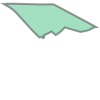

In [69]:
#here's the shape of the city district of Wittlaer as an example.
Polygon(shape(geo_df['Geometry'][9][0]['geometry']))

 next step is to create a list of coordinates for the charging stations from the dataframe.

In [70]:
cs_coordinates= []
print(type(cs_coordinates))
for cs_index in range(len(chargingstations_df)):
    cs_coordinates=cs_coordinates+[[chargingstations_df['Longitude'][cs_index],chargingstations_df['Latitude'][cs_index]]]

<class 'list'>


In [71]:
cs_coordinates

[[6.734488, 51.264739],
 [6.775946151928996, 51.22728034729124],
 [6.725486, 51.2372],
 [6.8124547, 51.222622],
 [6.7903395, 51.276635],
 [6.7823688, 51.2180413],
 [6.774657, 51.2353848],
 [6.82248, 51.2211178],
 [6.7935432, 51.2210909],
 [6.7803173, 51.2390381],
 [6.7857501, 51.2787614],
 [6.7694346, 51.2454296],
 [6.7808851, 51.2627009],
 [6.7770302, 51.213918],
 [6.8129154, 51.193844]]

Now we need an algorithm to determine in which district the charging stations are situated.

In [72]:
len(cs_coordinates)

15

In [73]:
districtsofstations=[]
print(districtsofstations)


[]


In [74]:
from shapely.geometry import shape, Point, Polygon

In [75]:
for i in range(len(cs_coordinates)):
    #first add an empty list which later will contain all the districts the station is in 
    #(to account for possible overlap we may need more than just a single entry per station)
    districtsofstations=districtsofstations+[[]]
    currentpoint=Point(cs_coordinates[i])
    for j in range(len(geo_df)):
        currentpolygon=Polygon(shape(geo_df['Geometry'][j][0]['geometry']))
        if (currentpolygon.contains(currentpoint)==True):
            districtsofstations[i]=districtsofstations[i]+[geo_df['City District'][j]]
    chargingstations_df['City District'][i]=str(districtsofstations[i])        
            
        

In [76]:
districtsofstations

[['Stockum'],
 ['Altstadt'],
 ['Heerdt'],
 ['Flingernsued'],
 ['Unterrath'],
 ['Friedrichstadt'],
 ['Pempelfort'],
 ['Lierenfeld'],
 ['Stadtmitte'],
 ['Pempelfort'],
 ['Unterrath'],
 ['Golzheim'],
 ['Derendorf'],
 ['Friedrichstadt'],
 ['Wersten']]

In [77]:
type(chargingstations_df['City District'][0])

str

In [78]:
chargingstations_df

Name Latitude Longitude       City District
0          Ladestation E-mobil NRW  51.2647   6.73449         ['Stockum']
1              Parkhaus Kunsthalle  51.2273   6.77595        ['Altstadt']
2                       Stromtanke  51.2372   6.72549          ['Heerdt']
3   Ladesäule Stadwerke Düsseldorf  51.2226   6.81245    ['Flingernsued']
4            Stadtwerke Düsseldorf  51.2766   6.79034       ['Unterrath']
5            Stadtwerke Düsseldorf   51.218   6.78237  ['Friedrichstadt']
6                              EON  51.2354   6.77466      ['Pempelfort']
7                         Mennekes  51.2211   6.82248      ['Lierenfeld']
8                  DB Energie GmbH  51.2211   6.79354      ['Stadtmitte']
9            Stadtwerke Düsseldorf   51.239   6.78032      ['Pempelfort']
10                     Parsevalstr  51.2788   6.78575       ['Unterrath']
11           Stadtwerke Düsseldorf  51.2454   6.76943        ['Golzheim']
12                        Aldi Süd  51.2627   6.78089       ['Derendorf']
13           Stadtwerke Düsseldorf  51.2139   6.77703  ['Friedrichstadt']
14           Stadtwerke Düsseldorf  51.1938   6.81292         ['Wersten']

Now let's change the formating of the 'city district' column, so that it just contains the proper name of the city district without any extra stuff surrounding it.

In [79]:
cs_districts=[]

In [80]:
len(chargingstations_df)

15

In [81]:
cs_districts=[]
for i in range(len(chargingstations_df)):
    cs_districts.append(chargingstations_df['City District'][i][2:len(chargingstations_df['City District'][i])-2])

In [82]:
cs_districts

['Stockum',
 'Altstadt',
 'Heerdt',
 'Flingernsued',
 'Unterrath',
 'Friedrichstadt',
 'Pempelfort',
 'Lierenfeld',
 'Stadtmitte',
 'Pempelfort',
 'Unterrath',
 'Golzheim',
 'Derendorf',
 'Friedrichstadt',
 'Wersten']

In [83]:
chargingstations_df['City District']=cs_districts

In [84]:
chargingstations_df

Name Latitude Longitude   City District
0          Ladestation E-mobil NRW  51.2647   6.73449         Stockum
1              Parkhaus Kunsthalle  51.2273   6.77595        Altstadt
2                       Stromtanke  51.2372   6.72549          Heerdt
3   Ladesäule Stadwerke Düsseldorf  51.2226   6.81245    Flingernsued
4            Stadtwerke Düsseldorf  51.2766   6.79034       Unterrath
5            Stadtwerke Düsseldorf   51.218   6.78237  Friedrichstadt
6                              EON  51.2354   6.77466      Pempelfort
7                         Mennekes  51.2211   6.82248      Lierenfeld
8                  DB Energie GmbH  51.2211   6.79354      Stadtmitte
9            Stadtwerke Düsseldorf   51.239   6.78032      Pempelfort
10                     Parsevalstr  51.2788   6.78575       Unterrath
11           Stadtwerke Düsseldorf  51.2454   6.76943        Golzheim
12                        Aldi Süd  51.2627   6.78089       Derendorf
13           Stadtwerke Düsseldorf  51.2139   6.77703  Friedrichstadt
14           Stadtwerke Düsseldorf  51.1938   6.81292         Wersten

In [85]:
locationresults_df.head()

categories  hasPerk  \
0  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
1  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
2  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
3  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   
4  [{'id': '5032872391d4c4b30a586d64', 'name': 'E...    False   

                         id  \
0  52ed20ad498e2e54e00ecd9e   
1  54a322af498ee5447093a998   
2  59a2d2ef35d3fc3e2ef955a7   
3  5938016ea6ec982d008f529d   
4  580b35c138fa00cd45c88331   

                                            location  \
0  {'address': 'Europaplatz 1', 'crossStreet': 'P...   
1  {'lat': 51.22728034729124, 'lng': 6.7759461519...   
2  {'lat': 51.205047, 'lng': 6.68897, 'labeledLat...   
3  {'address': 'Am Albertussee', 'lat': 51.2372, ...   
4  {'address': 'Höher Weg 100', 'lat': 51.222622,...   

                             name    referralId  
0         Ladestation E-mobil NRW  v-1590163334  
1             Parkhaus Kunsthalle  v-1590163334  
2                Innogy Ladesäule  v-1590163334  
3                      Stromtanke  v-1590163334  
4  Ladesäule Stadwerke Düsseldorf  v-1590163334

In [86]:
districts_df

City District Polygon Population Density [1/km^2]
0            NaN     NaN                         NaN
1            NaN     NaN                         NaN
2            NaN     NaN                         NaN
3            NaN     NaN                         NaN
4            NaN     NaN                         NaN
5            NaN     NaN                         NaN
6            NaN     NaN                         NaN
7            NaN     NaN                         NaN
8            NaN     NaN                         NaN
9            NaN     NaN                         NaN
10           NaN     NaN                         NaN
11           NaN     NaN                         NaN
12           NaN     NaN                         NaN
13           NaN     NaN                         NaN
14           NaN     NaN                         NaN
15           NaN     NaN                         NaN
16           NaN     NaN                         NaN
17           NaN     NaN                         NaN
18           NaN     NaN                         NaN
19           NaN     NaN                         NaN
20           NaN     NaN                         NaN
21           NaN     NaN                         NaN
22           NaN     NaN                         NaN
23           NaN     NaN                         NaN
24           NaN     NaN                         NaN
25           NaN     NaN                         NaN
26           NaN     NaN                         NaN
27           NaN     NaN                         NaN
28           NaN     NaN                         NaN
29           NaN     NaN                         NaN
30           NaN     NaN                         NaN
31           NaN     NaN                         NaN
32           NaN     NaN                         NaN
33           NaN     NaN                         NaN
34           NaN     NaN                         NaN
35           NaN     NaN                         NaN
36           NaN     NaN                         NaN
37           NaN     NaN                         NaN
38           NaN     NaN                         NaN
39           NaN     NaN                         NaN
40           NaN     NaN                         NaN
41           NaN     NaN                         NaN
42           NaN     NaN                         NaN
43           NaN     NaN                         NaN
44           NaN     NaN                         NaN
45           NaN     NaN                         NaN
46           NaN     NaN                         NaN
47           NaN     NaN                         NaN
48           NaN     NaN                         NaN
49           NaN     NaN                         NaN

In [87]:
geo_df

City District                                           Geometry  \
0            Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1        Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2        Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3       Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4            Itter  {'type': 'FeatureCollection', 'generator': 'JO...   
5             Rath  {'type': 'FeatureCollection', 'generator': 'JO...   
6        Derendorf  {'type': 'FeatureCollection', 'generator': 'JO...   
7    Moersenbroich  {'type': 'FeatureCollection', 'generator': 'JO...   
8     Niederkassel  {'type': 'FeatureCollection', 'generator': 'JO...   
9          Hassels  {'type': 'FeatureCollection', 'generator': 'JO...   
10         Loerick  {'type': 'FeatureCollection', 'generator': 'JO...   
11        Altstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
12         Wersten  {'type': 'FeatureCollection', 'generator': 'JO...   
13       Urdenbach  {'type': 'FeatureCollection', 'generator': 'JO...   
14      Hubbelrath  {'type': 'FeatureCollection', 'generator': 'JO...   
15        Wittlaer  {'type': 'FeatureCollection', 'generator': 'JO...   
16   Lichtenbroich  {'type': 'FeatureCollection', 'generator': 'JO...   
17    Kaiserswerth  {'type': 'FeatureCollection', 'generator': 'JO...   
18     Himmelgeist  {'type': 'FeatureCollection', 'generator': 'JO...   
19           Eller  {'type': 'FeatureCollection', 'generator': 'JO...   
20      Stadtmitte  {'type': 'FeatureCollection', 'generator': 'JO...   
21    Volmerswerth  {'type': 'FeatureCollection', 'generator': 'JO...   
22      Vennhausen  {'type': 'FeatureCollection', 'generator': 'JO...   
23      Gerresheim  {'type': 'FeatureCollection', 'generator': 'JO...   
24           Flehe  {'type': 'FeatureCollection', 'generator': 'JO...   
25      Grafenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
26          Heerdt  {'type': 'FeatureCollection', 'generator': 'JO...   
27       Unterbach  {'type': 'FeatureCollection', 'generator': 'JO...   
28       Angermund  {'type': 'FeatureCollection', 'generator': 'JO...   
29        Golzheim  {'type': 'FeatureCollection', 'generator': 'JO...   
30       Unterbilk  {'type': 'FeatureCollection', 'generator': 'JO...   
31    Flingernnord  {'type': 'FeatureCollection', 'generator': 'JO...   
32    Flingernsued  {'type': 'FeatureCollection', 'generator': 'JO...   
33  Friedrichstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
34        Oberbilk  {'type': 'FeatureCollection', 'generator': 'JO...   
35      Lierenfeld  {'type': 'FeatureCollection', 'generator': 'JO...   
36      Pempelfort  {'type': 'FeatureCollection', 'generator': 'JO...   
37         Stockum  {'type': 'FeatureCollection', 'generator': 'JO...   
38       Hellerhof  {'type': 'FeatureCollection', 'generator': 'JO...   
39       Knittkuhl  {'type': 'FeatureCollection', 'generator': 'JO...   
40        Lohausen  {'type': 'FeatureCollection', 'generator': 'JO...   
41            Hamm  {'type': 'FeatureCollection', 'generator': 'JO...   
42       Unterrath  {'type': 'FeatureCollection', 'generator': 'JO...   
43          Garath  {'type': 'FeatureCollection', 'generator': 'JO...   
44        Reisholz  {'type': 'FeatureCollection', 'generator': 'JO...   
45            Bilk  {'type': 'FeatureCollection', 'generator': 'JO...   
46      Oberkassel  {'type': 'FeatureCollection', 'generator': 'JO...   
47         Benrath  {'type': 'FeatureCollection', 'generator': 'JO...   
48          Kalkum  {'type': 'FeatureCollection', 'generator': 'JO...   
49      Duesseltal  {'type': 'FeatureCollection', 'generator': 'JO...   

                                           Type  
0   <class 'geojson.feature.FeatureCollection'>  
1   <class 'geojson.feature.FeatureCollection'>  
2   <class 'geojson.feature.FeatureCollection'>  
3   <class 'geojson.feature.FeatureCollection'>  
4   <class 'geojson.feature.Fea

In [88]:
districts_df

City District Polygon Population Density [1/km^2]
0            NaN     NaN                         NaN
1            NaN     NaN                         NaN
2            NaN     NaN                         NaN
3            NaN     NaN                         NaN
4            NaN     NaN                         NaN
5            NaN     NaN                         NaN
6            NaN     NaN                         NaN
7            NaN     NaN                         NaN
8            NaN     NaN                         NaN
9            NaN     NaN                         NaN
10           NaN     NaN                         NaN
11           NaN     NaN                         NaN
12           NaN     NaN                         NaN
13           NaN     NaN                         NaN
14           NaN     NaN                         NaN
15           NaN     NaN                         NaN
16           NaN     NaN                         NaN
17           NaN     NaN                         NaN
18           NaN     NaN                         NaN
19           NaN     NaN                         NaN
20           NaN     NaN                         NaN
21           NaN     NaN                         NaN
22           NaN     NaN                         NaN
23           NaN     NaN                         NaN
24           NaN     NaN                         NaN
25           NaN     NaN                         NaN
26           NaN     NaN                         NaN
27           NaN     NaN                         NaN
28           NaN     NaN                         NaN
29           NaN     NaN                         NaN
30           NaN     NaN                         NaN
31           NaN     NaN                         NaN
32           NaN     NaN                         NaN
33           NaN     NaN                         NaN
34           NaN     NaN                         NaN
35           NaN     NaN                         NaN
36           NaN     NaN                         NaN
37           NaN     NaN                         NaN
38           NaN     NaN                         NaN
39           NaN     NaN                         NaN
40           NaN     NaN                         NaN
41           NaN     NaN                         NaN
42           NaN     NaN                         NaN
43           NaN     NaN                         NaN
44           NaN     NaN                         NaN
45           NaN     NaN                         NaN
46           NaN     NaN                         NaN
47           NaN     NaN                         NaN
48           NaN     NaN                         NaN
49           NaN     NaN                         NaN

In [89]:
districts_df['City District']=geo_df['City District']

In [90]:
districts_df

City District Polygon Population Density [1/km^2]
0            Hafen     NaN                         NaN
1        Ludenberg     NaN                         NaN
2        Carlstadt     NaN                         NaN
3       Holthausen     NaN                         NaN
4            Itter     NaN                         NaN
5             Rath     NaN                         NaN
6        Derendorf     NaN                         NaN
7    Moersenbroich     NaN                         NaN
8     Niederkassel     NaN                         NaN
9          Hassels     NaN                         NaN
10         Loerick     NaN                         NaN
11        Altstadt     NaN                         NaN
12         Wersten     NaN                         NaN
13       Urdenbach     NaN                         NaN
14      Hubbelrath     NaN                         NaN
15        Wittlaer     NaN                         NaN
16   Lichtenbroich     NaN                         NaN
17    Kaiserswerth     NaN                         NaN
18     Himmelgeist     NaN                         NaN
19           Eller     NaN                         NaN
20      Stadtmitte     NaN                         NaN
21    Volmerswerth     NaN                         NaN
22      Vennhausen     NaN                         NaN
23      Gerresheim     NaN                         NaN
24           Flehe     NaN                         NaN
25      Grafenberg     NaN                         NaN
26          Heerdt     NaN                         NaN
27       Unterbach     NaN                         NaN
28       Angermund     NaN                         NaN
29        Golzheim     NaN                         NaN
30       Unterbilk     NaN                         NaN
31    Flingernnord     NaN                         NaN
32    Flingernsued     NaN                         NaN
33  Friedrichstadt     NaN                         NaN
34        Oberbilk     NaN                         NaN
35      Lierenfeld     NaN                         NaN
36      Pempelfort     NaN                         NaN
37         Stockum     NaN                         NaN
38       Hellerhof     NaN                         NaN
39       Knittkuhl     NaN                         NaN
40        Lohausen     NaN                         NaN
41            Hamm     NaN                         NaN
42       Unterrath     NaN                         NaN
43          Garath     NaN                         NaN
44        Reisholz     NaN                         NaN
45            Bilk     NaN                         NaN
46      Oberkassel     NaN                         NaN
47         Benrath     NaN                         NaN
48          Kalkum     NaN                         NaN
49      Duesseltal     NaN                         NaN

Next, enter the population density for each district (source: https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_D%C3%BCsseldorf )

In [91]:
population_density_list=[32,1077,4804,2276,749,1819,5801,5219,2690,3823,2778,3971,6062,1364,250,1132,2646,1669,306,5127,7581,1015,2915,4154,1215,5775,2232,781,455,4335,10952,7939,6395,17152,7282,3850,10417,748,3165,2291,334,973,4715,5002,1994,6704,4551,2673,249,8693]
for i in range(len(population_density_list)):
    districts_df['Population Density [1/km^2]'][i]=population_density_list[i]

In [92]:
districts_df.sort_values(by='City District')

City District Polygon Population Density [1/km^2]
11        Altstadt     NaN                        3971
28       Angermund     NaN                         455
47         Benrath     NaN                        2673
45            Bilk     NaN                        6704
2        Carlstadt     NaN                        4804
6        Derendorf     NaN                        5801
49      Duesseltal     NaN                        8693
19           Eller     NaN                        5127
24           Flehe     NaN                        1215
31    Flingernnord     NaN                        7939
32    Flingernsued     NaN                        6395
33  Friedrichstadt     NaN                       17152
43          Garath     NaN                        5002
23      Gerresheim     NaN                        4154
29        Golzheim     NaN                        4335
25      Grafenberg     NaN                        5775
0            Hafen     NaN                          32
41            Hamm     NaN                         973
9          Hassels     NaN                        3823
26          Heerdt     NaN                        2232
38       Hellerhof     NaN                        3165
18     Himmelgeist     NaN                         306
3       Holthausen     NaN                        2276
14      Hubbelrath     NaN                         250
4            Itter     NaN                         749
17    Kaiserswerth     NaN                        1669
48          Kalkum     NaN                         249
39       Knittkuhl     NaN                        2291
16   Lichtenbroich     NaN                        2646
35      Lierenfeld     NaN                        3850
10         Loerick     NaN                        2778
40        Lohausen     NaN                         334
1        Ludenberg     NaN                        1077
7    Moersenbroich     NaN                        5219
8     Niederkassel     NaN                        2690
34        Oberbilk     NaN                        7282
46      Oberkassel     NaN                        4551
36      Pempelfort     NaN                       10417
5             Rath     NaN                        1819
44        Reisholz     NaN                        1994
20      Stadtmitte     NaN                        7581
37         Stockum     NaN                         748
27       Unterbach     NaN                         781
30       Unterbilk     NaN                       10952
42       Unterrath     NaN                        4715
13       Urdenbach     NaN                        1364
22      Vennhausen     NaN                        2915
21    Volmerswerth     NaN                        1015
12         Wersten     NaN                        6062
15        Wittlaer     NaN                        1132

In [93]:
districts_df

City District Polygon Population Density [1/km^2]
0            Hafen     NaN                          32
1        Ludenberg     NaN                        1077
2        Carlstadt     NaN                        4804
3       Holthausen     NaN                        2276
4            Itter     NaN                         749
5             Rath     NaN                        1819
6        Derendorf     NaN                        5801
7    Moersenbroich     NaN                        5219
8     Niederkassel     NaN                        2690
9          Hassels     NaN                        3823
10         Loerick     NaN                        2778
11        Altstadt     NaN                        3971
12         Wersten     NaN                        6062
13       Urdenbach     NaN                        1364
14      Hubbelrath     NaN                         250
15        Wittlaer     NaN                        1132
16   Lichtenbroich     NaN                        2646
17    Kaiserswerth     NaN                        1669
18     Himmelgeist     NaN                         306
19           Eller     NaN                        5127
20      Stadtmitte     NaN                        7581
21    Volmerswerth     NaN                        1015
22      Vennhausen     NaN                        2915
23      Gerresheim     NaN                        4154
24           Flehe     NaN                        1215
25      Grafenberg     NaN                        5775
26          Heerdt     NaN                        2232
27       Unterbach     NaN                         781
28       Angermund     NaN                         455
29        Golzheim     NaN                        4335
30       Unterbilk     NaN                       10952
31    Flingernnord     NaN                        7939
32    Flingernsued     NaN                        6395
33  Friedrichstadt     NaN                       17152
34        Oberbilk     NaN                        7282
35      Lierenfeld     NaN                        3850
36      Pempelfort     NaN                       10417
37         Stockum     NaN                         748
38       Hellerhof     NaN                        3165
39       Knittkuhl     NaN                        2291
40        Lohausen     NaN                         334
41            Hamm     NaN                         973
42       Unterrath     NaN                        4715
43          Garath     NaN                        5002
44        Reisholz     NaN                        1994
45            Bilk     NaN                        6704
46      Oberkassel     NaN                        4551
47         Benrath     NaN                        2673
48          Kalkum     NaN                         249
49      Duesseltal     NaN                        8693

In [94]:
geo_df

City District                                           Geometry  \
0            Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1        Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2        Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3       Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4            Itter  {'type': 'FeatureCollection', 'generator': 'JO...   
5             Rath  {'type': 'FeatureCollection', 'generator': 'JO...   
6        Derendorf  {'type': 'FeatureCollection', 'generator': 'JO...   
7    Moersenbroich  {'type': 'FeatureCollection', 'generator': 'JO...   
8     Niederkassel  {'type': 'FeatureCollection', 'generator': 'JO...   
9          Hassels  {'type': 'FeatureCollection', 'generator': 'JO...   
10         Loerick  {'type': 'FeatureCollection', 'generator': 'JO...   
11        Altstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
12         Wersten  {'type': 'FeatureCollection', 'generator': 'JO...   
13       Urdenbach  {'type': 'FeatureCollection', 'generator': 'JO...   
14      Hubbelrath  {'type': 'FeatureCollection', 'generator': 'JO...   
15        Wittlaer  {'type': 'FeatureCollection', 'generator': 'JO...   
16   Lichtenbroich  {'type': 'FeatureCollection', 'generator': 'JO...   
17    Kaiserswerth  {'type': 'FeatureCollection', 'generator': 'JO...   
18     Himmelgeist  {'type': 'FeatureCollection', 'generator': 'JO...   
19           Eller  {'type': 'FeatureCollection', 'generator': 'JO...   
20      Stadtmitte  {'type': 'FeatureCollection', 'generator': 'JO...   
21    Volmerswerth  {'type': 'FeatureCollection', 'generator': 'JO...   
22      Vennhausen  {'type': 'FeatureCollection', 'generator': 'JO...   
23      Gerresheim  {'type': 'FeatureCollection', 'generator': 'JO...   
24           Flehe  {'type': 'FeatureCollection', 'generator': 'JO...   
25      Grafenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
26          Heerdt  {'type': 'FeatureCollection', 'generator': 'JO...   
27       Unterbach  {'type': 'FeatureCollection', 'generator': 'JO...   
28       Angermund  {'type': 'FeatureCollection', 'generator': 'JO...   
29        Golzheim  {'type': 'FeatureCollection', 'generator': 'JO...   
30       Unterbilk  {'type': 'FeatureCollection', 'generator': 'JO...   
31    Flingernnord  {'type': 'FeatureCollection', 'generator': 'JO...   
32    Flingernsued  {'type': 'FeatureCollection', 'generator': 'JO...   
33  Friedrichstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
34        Oberbilk  {'type': 'FeatureCollection', 'generator': 'JO...   
35      Lierenfeld  {'type': 'FeatureCollection', 'generator': 'JO...   
36      Pempelfort  {'type': 'FeatureCollection', 'generator': 'JO...   
37         Stockum  {'type': 'FeatureCollection', 'generator': 'JO...   
38       Hellerhof  {'type': 'FeatureCollection', 'generator': 'JO...   
39       Knittkuhl  {'type': 'FeatureCollection', 'generator': 'JO...   
40        Lohausen  {'type': 'FeatureCollection', 'generator': 'JO...   
41            Hamm  {'type': 'FeatureCollection', 'generator': 'JO...   
42       Unterrath  {'type': 'FeatureCollection', 'generator': 'JO...   
43          Garath  {'type': 'FeatureCollection', 'generator': 'JO...   
44        Reisholz  {'type': 'FeatureCollection', 'generator': 'JO...   
45            Bilk  {'type': 'FeatureCollection', 'generator': 'JO...   
46      Oberkassel  {'type': 'FeatureCollection', 'generator': 'JO...   
47         Benrath  {'type': 'FeatureCollection', 'generator': 'JO...   
48          Kalkum  {'type': 'FeatureCollection', 'generator': 'JO...   
49      Duesseltal  {'type': 'FeatureCollection', 'generator': 'JO...   

                                           Type  
0   <class 'geojson.feature.FeatureCollection'>  
1   <class 'geojson.feature.FeatureCollection'>  
2   <class 'geojson.feature.FeatureCollection'>  
3   <class 'geojson.feature.FeatureCollection'>  
4   <class 'geojson.feature.Fea

As a next step, let's create a map where all the districts are shown (with information on population density popping up when hovering above it) as well as with the existing EV stations.

In [95]:
geo_df['Population Density [1/km^2]']=districts_df['Population Density [1/km^2]']

In [96]:
for i in range(len(geo_df['Geometry'])):
    folium.GeoJson(geo_df['Geometry'][i]).add_to(duesseldorf_map)

In [97]:
duesseldorf_map

In [98]:
geo_df['Geometry']=polygoncontents

In [99]:
polygoncontents[0]==geo_df['Geometry'][0]

True

In [100]:
geo_df['Polygon']='bla'
for i in range(len(geo_df['Geometry'])):
    geo_df['Polygon'][i]=Polygon(shape(geo_df['Geometry'][i][0]['geometry']))

In [101]:
geo_df.head()

City District                                           Geometry  \
0         Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1     Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2     Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3    Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4         Itter  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type Population Density [1/km^2]  \
0  <class 'geojson.feature.FeatureCollection'>                          32   
1  <class 'geojson.feature.FeatureCollection'>                        1077   
2  <class 'geojson.feature.FeatureCollection'>                        4804   
3  <class 'geojson.feature.FeatureCollection'>                        2276   
4  <class 'geojson.feature.FeatureCollection'>                         749   

                                             Polygon  
0  POLYGON ((6.730208 51.208949, 6.729931 51.2094...  
1  POLYGON ((6.879068 51.261155, 6.878906 51.2604...  
2  POLYGON ((6.775664 51.225005, 6.775456 51.2249...  
3  POLYGON ((6.853443 51.17138, 6.853407 51.17129...  
4  POLYGON ((6.826055 51.157212, 6.823194 51.1611...

In [102]:
type(geo_df['Polygon'][0])

shapely.geometry.polygon.Polygon

In [103]:
type(geo_df['Polygon'][0])

shapely.geometry.polygon.Polygon

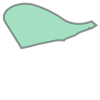

In [104]:
geo_df['Polygon'][0]

In [105]:
#duesseldorf_map.choropleth(
#    geo_data=geojson,
#    name='Population Density',
#    data=geo_df,
#    columns=['Polygon', 'Population Density [1/km^2]'],
#   fill_color='YlGn',
#    key_on='feature.geometry.name',
#    legend_name='Population Density'
#)  

In [106]:
type(geo_df)

geopandas.geodataframe.GeoDataFrame

create a colormap for the choropleth map of the population densities.

In [107]:
from branca.colormap import linear

colormap = linear.YlGn_09.scale(
    geo_df['Population Density [1/km^2]'].min(),
    geo_df['Population Density [1/km^2]'].max())

print(colormap(5.0))

colormap



#ffffe5ff


In [108]:
geo_df.head()

City District                                           Geometry  \
0         Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1     Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2     Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3    Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4         Itter  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type Population Density [1/km^2]  \
0  <class 'geojson.feature.FeatureCollection'>                          32   
1  <class 'geojson.feature.FeatureCollection'>                        1077   
2  <class 'geojson.feature.FeatureCollection'>                        4804   
3  <class 'geojson.feature.FeatureCollection'>                        2276   
4  <class 'geojson.feature.FeatureCollection'>                         749   

                                             Polygon  
0  POLYGON ((6.730208 51.208949, 6.729931 51.2094...  
1  POLYGON ((6.879068 51.261155, 6.878906 51.2604...  
2  POLYGON ((6.775664 51.225005, 6.775456 51.2249...  
3  POLYGON ((6.853443 51.17138, 6.853407 51.17129...  
4  POLYGON ((6.826055 51.157212, 6.823194 51.1611...

In [109]:
geojson_polygons=[]
for i in range(len(geo_df['Polygon'])):
    geojson_polygons.append(shapely.geometry.mapping(geo_df['Polygon'][i]))

In [110]:
geojson_polygons

[{'type': 'Polygon',
  'coordinates': (((6.730208, 51.208949),
    (6.729931, 51.209485),
    (6.726477, 51.215022),
    (6.723154, 51.220264),
    (6.722751, 51.220983),
    (6.722469, 51.221712),
    (6.722338, 51.222355),
    (6.722257, 51.222994),
    (6.722378, 51.223841),
    (6.722638, 51.224506),
    (6.723008, 51.225243),
    (6.72352, 51.225931),
    (6.724229, 51.226628),
    (6.72503, 51.227246),
    (6.725838, 51.227716),
    (6.72672, 51.22815),
    (6.727863, 51.228574),
    (6.729118, 51.228903),
    (6.730159, 51.229101),
    (6.731172, 51.229241),
    (6.732595, 51.229271),
    (6.73461, 51.229142),
    (6.736375, 51.228765),
    (6.738956, 51.227885),
    (6.741033, 51.227058),
    (6.743009, 51.226186),
    (6.744626, 51.225379),
    (6.746792, 51.224205),
    (6.748771, 51.222946),
    (6.75014, 51.222003),
    (6.750986, 51.221486),
    (6.751841, 51.22099),
    (6.752923, 51.220585),
    (6.754042, 51.220241),
    (6.75506, 51.220036),
    (6.756112, 51.219889),


In [111]:
type(geojson_polygons[0])

dict

next step: create a suitable geojson file from this for the creation of a choropleth map.

In [112]:
geo_df['Geometry'][0]['features'][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [113]:
for i in range(len(geo_df)):
    geo_df['Geometry'][i]['features'][0]['id']=str(geo_df['City District'][i])
    geo_df['Geometry'][i]['features'][0]['properties']={'name':str(geo_df['City District'][i])}

In [114]:
geo_df['Geometry'][0]['features'][0].keys()

dict_keys(['type', 'geometry', 'properties', 'id'])

In [115]:
geo_df['Geometry'][0]

{"features": [{"geometry": {"coordinates": [[6.730208, 51.208949], [6.729931, 51.209485], [6.726477, 51.215022], [6.723154, 51.220264], [6.722751, 51.220983], [6.722469, 51.221712], [6.722338, 51.222355], [6.722257, 51.222994], [6.722378, 51.223841], [6.722638, 51.224506], [6.723008, 51.225243], [6.72352, 51.225931], [6.724229, 51.226628], [6.72503, 51.227246], [6.725838, 51.227716], [6.72672, 51.22815], [6.727863, 51.228574], [6.729118, 51.228903], [6.730159, 51.229101], [6.731172, 51.229241], [6.732595, 51.229271], [6.73461, 51.229142], [6.736375, 51.228765], [6.738956, 51.227885], [6.741033, 51.227058], [6.743009, 51.226186], [6.744626, 51.225379], [6.746792, 51.224205], [6.748771, 51.222946], [6.75014, 51.222003], [6.750986, 51.221486], [6.751841, 51.22099], [6.752923, 51.220585], [6.754042, 51.220241], [6.75506, 51.220036], [6.756112, 51.219889], [6.757373, 51.219809], [6.75866, 51.219852], [6.759929, 51.219991], [6.761157, 51.220217], [6.762587, 51.220664], [6.763487, 51.221052],

In [116]:
geojson_for_choropleth=geo_df['Geometry'][0]

In [117]:
for j in range(len(geo_df)-1):
    geojson_for_choropleth['features'].append(geo_df['Geometry'][j+1]['features'][0])

In [118]:
geojson_for_choropleth

{"features": [{"geometry": {"coordinates": [[6.730208, 51.208949], [6.729931, 51.209485], [6.726477, 51.215022], [6.723154, 51.220264], [6.722751, 51.220983], [6.722469, 51.221712], [6.722338, 51.222355], [6.722257, 51.222994], [6.722378, 51.223841], [6.722638, 51.224506], [6.723008, 51.225243], [6.72352, 51.225931], [6.724229, 51.226628], [6.72503, 51.227246], [6.725838, 51.227716], [6.72672, 51.22815], [6.727863, 51.228574], [6.729118, 51.228903], [6.730159, 51.229101], [6.731172, 51.229241], [6.732595, 51.229271], [6.73461, 51.229142], [6.736375, 51.228765], [6.738956, 51.227885], [6.741033, 51.227058], [6.743009, 51.226186], [6.744626, 51.225379], [6.746792, 51.224205], [6.748771, 51.222946], [6.75014, 51.222003], [6.750986, 51.221486], [6.751841, 51.22099], [6.752923, 51.220585], [6.754042, 51.220241], [6.75506, 51.220036], [6.756112, 51.219889], [6.757373, 51.219809], [6.75866, 51.219852], [6.759929, 51.219991], [6.761157, 51.220217], [6.762587, 51.220664], [6.763487, 51.221052],

change the actual geometrical data from geojson type linestring to geojson type polygon for future use:

In [119]:
for k in range(len(geojson_for_choropleth['features'])):    
    geojson_for_choropleth['features'][k]['geometry']['type']=geojson_for_choropleth['features'][k]['geometry']['type'].replace('LineString','Polygon')

In [120]:
geojson_for_choropleth

{"features": [{"geometry": {"coordinates": [[6.730208, 51.208949], [6.729931, 51.209485], [6.726477, 51.215022], [6.723154, 51.220264], [6.722751, 51.220983], [6.722469, 51.221712], [6.722338, 51.222355], [6.722257, 51.222994], [6.722378, 51.223841], [6.722638, 51.224506], [6.723008, 51.225243], [6.72352, 51.225931], [6.724229, 51.226628], [6.72503, 51.227246], [6.725838, 51.227716], [6.72672, 51.22815], [6.727863, 51.228574], [6.729118, 51.228903], [6.730159, 51.229101], [6.731172, 51.229241], [6.732595, 51.229271], [6.73461, 51.229142], [6.736375, 51.228765], [6.738956, 51.227885], [6.741033, 51.227058], [6.743009, 51.226186], [6.744626, 51.225379], [6.746792, 51.224205], [6.748771, 51.222946], [6.75014, 51.222003], [6.750986, 51.221486], [6.751841, 51.22099], [6.752923, 51.220585], [6.754042, 51.220241], [6.75506, 51.220036], [6.756112, 51.219889], [6.757373, 51.219809], [6.75866, 51.219852], [6.759929, 51.219991], [6.761157, 51.220217], [6.762587, 51.220664], [6.763487, 51.221052],

In [121]:
#in order to make the variable fit the geojson syntax for polygons.
for k in range(len(geojson_for_choropleth['features'])):    
    geojson_for_choropleth['features'][k]['geometry']['coordinates']=[geojson_for_choropleth['features'][k]['geometry']['coordinates']]
  

In [122]:
geojson_for_choropleth

{"features": [{"geometry": {"coordinates": [[[6.730208, 51.208949], [6.729931, 51.209485], [6.726477, 51.215022], [6.723154, 51.220264], [6.722751, 51.220983], [6.722469, 51.221712], [6.722338, 51.222355], [6.722257, 51.222994], [6.722378, 51.223841], [6.722638, 51.224506], [6.723008, 51.225243], [6.72352, 51.225931], [6.724229, 51.226628], [6.72503, 51.227246], [6.725838, 51.227716], [6.72672, 51.22815], [6.727863, 51.228574], [6.729118, 51.228903], [6.730159, 51.229101], [6.731172, 51.229241], [6.732595, 51.229271], [6.73461, 51.229142], [6.736375, 51.228765], [6.738956, 51.227885], [6.741033, 51.227058], [6.743009, 51.226186], [6.744626, 51.225379], [6.746792, 51.224205], [6.748771, 51.222946], [6.75014, 51.222003], [6.750986, 51.221486], [6.751841, 51.22099], [6.752923, 51.220585], [6.754042, 51.220241], [6.75506, 51.220036], [6.756112, 51.219889], [6.757373, 51.219809], [6.75866, 51.219852], [6.759929, 51.219991], [6.761157, 51.220217], [6.762587, 51.220664], [6.763487, 51.221052]

In [123]:
folium.Choropleth(
    geo_data=geojson_for_choropleth,
    name='Population Density',
    data=geo_df,
    columns=['City District', 'Population Density [1/km^2]'],
    fill_color='YlGn',
    fill_opacity=0.5,
    key_on='feature.id',
    legend_name='Population per square km'
).add_to(duesseldorf_map)  

In [124]:
duesseldorf_map

From the above map, it is also apparent that in general there is a higher concentration of charging stations in areas with a higher population density.

In [125]:
duesseldorf_map.save(outfile='results/choroplethmap_withstations.html')

In [126]:
type(geo_df['City District'][0])

str

In [127]:
geo_df.head()

City District                                           Geometry  \
0         Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1     Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2     Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3    Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4         Itter  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type Population Density [1/km^2]  \
0  <class 'geojson.feature.FeatureCollection'>                          32   
1  <class 'geojson.feature.FeatureCollection'>                        1077   
2  <class 'geojson.feature.FeatureCollection'>                        4804   
3  <class 'geojson.feature.FeatureCollection'>                        2276   
4  <class 'geojson.feature.FeatureCollection'>                         749   

                                             Polygon  
0  POLYGON ((6.730208 51.208949, 6.729931 51.2094...  
1  POLYGON ((6.879068 51.261155, 6.878906 51.2604...  
2  POLYGON ((6.775664 51.225005, 6.775456 51.2249...  
3  POLYGON ((6.853443 51.17138, 6.853407 51.17129...  
4  POLYGON ((6.826055 51.157212, 6.823194 51.1611...

Next, let's create a histogram of the population density, to see how the population density varies across districts.

In [128]:
import seaborn as sns

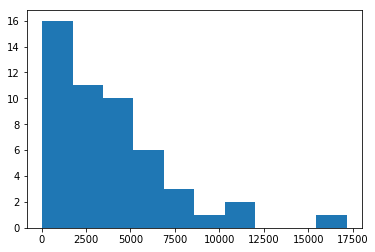

In [129]:
ran = int((max(geo_df['Population Density [1/km^2]'])) - min(geo_df['Population Density [1/km^2]']))+1
bins= plt.hist(geo_df['Population Density [1/km^2]'], bins=10)[1]

In [130]:
len(bins)

11

In [131]:
bins

array([32.0, 1744.0, 3456.0, 5168.0, 6880.0, 8592.0, 10304.0, 12016.0,
       13728.0, 15440.0, 17152.0], dtype=object)

In [132]:
type(bins[0])

float

In [133]:
testbin=int(bins[0])
type(testbin)

int

In [134]:
bins2=[]
for i in range(len(bins)):
    bins2.append(int(bins[i]))

In [135]:
bins2

[32, 1744, 3456, 5168, 6880, 8592, 10304, 12016, 13728, 15440, 17152]

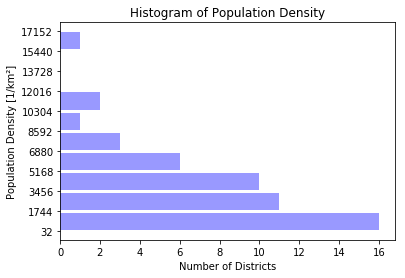

In [136]:
#n,bins,patches=plt.hist(geo_df2['Population Density [1/km^2]'])
ax=sns.distplot(geo_df['Population Density [1/km^2]'],kde=False,bins=10,hist_kws={'rwidth':0.85,'color':'blue'},vertical=True)
#plt.bar(bin_edges[:-1], hist, width = 0.5, color='blue', alpha=0.7)
#plt.xlim(min(bin_edges), max(bin_edges))
plt.title('Histogram of Population Density')
plt.xlabel('Number of Districts')
plt.ylabel('Population Density [1/km²]')
ax.set_yticks(bins2)
plt.savefig('results/histogram_popden.png')

As can be seen, more than 40 out of the 50 city districts of Düsseldorf have a population density of 7000 per square kilometer or less and one district has by far the highest population density of more than double that number. That district is the central district of Friedrichstadt.

# Algorithm to Find Best Place for New Charging Station

## Introduction and Basic Principle behind Algorithm

Now that we have the coordinates of the existing charging stations as well as the population density for a each district of the city of Düsseldorf, we need an algorithm to determine the optimal place for a new charging station. The basic aim will be to have an 'available population' number as large as possible within a 'certain radius' around the new placement position. Available population will be defined as population divided by the number of charging stations, whose radius covers the position in question. The 'certain radius' mentioned above shall be defined as half the average distance between charging stations which directly neighbor one another.

This model has some limitations based on the underlying assumptions. For example the number of electric vehicles per population may differ from district to district, depending for example on the income of the population. One could use the average rent in each district as a measure of this - on the other hand, if the rent is higher, the maintenance costs for the hypothetical new charging stations also go up. Therefore these finer points are outside of this model and of the results from the algorithm developed here.  

## Necessary Ingredients for the Algorithm

### 1. a function to determine the area of a geometrical shape in 2D, including of intersecting geometrical figures, A(geometry)
### 2. determining the radius of the 'circle of influence'
### 3. a function that gives the 'available population' within the circle of influence from a given point, a_p(pos, radius)
### 4. a grid of points over the entire city for which to apply the avai_pop function (dense enough for meaningful results, but not so dense that the algorithm takes forever to compute)
### 5. determining the grid point(s) with the maximum number of available population, i.e. max(avai_pop) over all grid points from 4.
### 6. visualisation of the results

## Combining 1. and 3. : Determining the Available Population inside the Circle of Influence Without Area Calculations

A relatively simple approach to take is to first put a grid onto the circle area and for each point of this grid determine the population density of the respective district. Then in the end determine the average population density over all of these grid points and multiply with the circle area. Kind of similar to a Monte Carlo approach. This is probably much simpler than determining accurately the area of the resulting intersecting geometrical shapes of circles and polygons.

Overlap between different circles of influence can be taken into account by taking a circle around each grid point and counting the number of stations within its radius.

### Concrete Description of Algorithm

We need to define the function avai_pop(pos, radius), where the radius is constant and 'pos' is a set of coordinates. Within that function we need to use a station_counting_function depending on the radius, which loops over all the coordinates of the existing stations to determine whether they are inside and which maintains a counter. We also need to determine for each grid point within the cricle around 'pos' the district this grid point is located in and then look up its population density from a suitable dataframe, e.g. geo_df2. The ratio of that population density and the counter result is then returned to the origin of the function call and gives the available population density for that grid point. This value can be noted in a 2D array or a dataframe. In the end we determine the average over all these values and multiply it by the area of the circle. This is the return value of avai_pop(pos, radius).  

In [137]:
import time

In [138]:
#the following variable was important for testing the duration of one part of the program in order to optimize runtime.
sum_of_stacoutimes=0

In [139]:
import math

#earth's radius in kilometers:
rad_earth=6371.009

#variable for efficiency testing
sum_of_stacoutimes=0

def geo_dist_km (point1_lon,point1_lat,point2_lon,point2_lat):
    #The distance calculation used here is the one described in https://en.wikipedia.org/wiki/Geographical_distance, 
    #section 'Spherical Earth projected to a plane'
    meanlat=(point1_lat+point2_lat)/2.0
    geodistance= rad_earth*math.sqrt((point1_lat*math.pi/180.0-point2_lat*math.pi/180.0)**2+(math.cos(meanlat*math.pi/180.0)*(point1_lon*math.pi/180.0-point2_lon*math.pi/180.0))**2)
    return geodistance

def geo_dist_km_fast (point1_lon,point1_lat,point2_lon,point2_lat):
    #this is easier to calculate according to https://jonisalonen.com/2014/computing-distance-between-coordinates-can-be-simple-and-fast/
    #and the error is apparently acceptable for the situation at hand.
    constlatdist=110.25
    difflat=point1_lat-point2_lat
    difflon=(point1_lon-point2_lon)*math.cos(point2_lat*math.pi/180.0)
    geodistance= constlatdist*math.sqrt(difflat**2+difflon**2)
    return geodistance

def station_counting_function(lonpoint,latpoint,locradius):
    #we're going to need this testing variable in here.
    global sum_of_stacoutimes
    #locradius is the radius in kilometers
    station_counter=0
    #The following loop over all existing stations compares their distance from the given point,
    #then compares to the radius. If the station is in the cirle, the counter is raised by one. 
    for i in range(len(chargingstations_df)):
        stacoutime_start=time.time()
        stationlat=chargingstations_df['Latitude'][i]
        stationlon=chargingstations_df['Longitude'][i]
        #meanlat=(stationlat+latpoint)/2.0
        #print('to test variables: ', 'iteration number: ', i, 'stationlat: ',stationlat,'stationlon: ', stationlon, 'latpoint: ', latpoint, 'lonpoint: ', lonpoint)
        #print('term test for this iteration:', 'stationlat*math.pi/180.0-latpoint*math.pi/180.0: ', stationlat*math.pi/180.0-latpoint*math.pi/180.0, 'math.cos(meanlat*math.pi/180.0): ', math.cos(meanlat*math.pi/180.0), 'stationlon*math.pi/180.0-lonpoint*math.pi/180.0:', stationlon*math.pi/180.0-lonpoint*math.pi/180.0)
        #distance in kilometers:
        #distance= rad_earth*math.sqrt((stationlat*math.pi/180.0-latpoint*math.pi/180.0)**2+(math.cos(meanlat*math.pi/180.0)*(stationlon*math.pi/180.0-lonpoint*math.pi/180.0))**2)
        distance= geo_dist_km_fast(stationlon,stationlat,lonpoint,latpoint)
        #print('distance: ', distance,'km')
        if (distance < locradius):
            station_counter= station_counter+1
        #print('number of stations in circle so far: ', station_counter)
        stacoutime_stop=time.time()
        stacoutime_duration=stacoutime_stop-stacoutime_start
        #print('station counting routine duration: ', stacoutime_duration)
        sum_of_stacoutimes=sum_of_stacoutimes+stacoutime_duration
    return station_counter

def avai_pop(poslon,poslat,radius,griddensity):
    avaipoptime_start=time.time()
    global sum_of_stacoutimes
    sum_of_stacoutimes=0
    #as a first step, we need to define the grid of points within our circle.
    #let's first start with a bounding box in geometrical coordinates as per http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates
    #which itself is based on the math handbook by Bronstein, Semendjajew, (see p.182f in the 9th ed. (German),2013)
    delta_lat= radius/rad_earth
    #this is the change in latitude in radian if you move along a meridian over a radial distance. 
    #That this is correct can be seen when considering that the crossed distance ('radius' in our case) along any meridian  
    #is proportional to the change in latitude and that in case of 'radius'=earth's circumference the result should
    #be 2PI. In other words, it has to be delta_lat= 2PI * (radius/(2PI*rad_earth)). The 2PI terms cancel out and
    #we're left with above term.
    latmin=(math.pi/180)*poslat-delta_lat
    latmax=(math.pi/180)*poslat+delta_lat
    #these are the limits of the bounding box for the latitude. This is fairly straightforward 
    #as there is a fixed ratio between spherical distance and a change in latitude with a fixed longitude 
    #(i.e. along a meridian). The formulas for minimum and maximum longitude are a bit more complicated.
    latitude_t=math.asin(math.sin((math.pi/180)*poslat)/math.cos(delta_lat))
    #this term is the latitude of the points on the spherical circle with the most extreme longitudinal values of the circle. 
    #Their latitude is different from 'poslat', which makes this case more complicated than the latitude case, where
    #the extreme points had been on the same longitude as 'poslon'.
    #start1=time.time()
    delta_lon=math.acos((math.cos(delta_lat)-math.sin(latitude_t)*math.sin((math.pi/180)*poslat))/(math.cos(latitude_t)*math.cos((math.pi/180)*poslat)))
    #end1=time.time()
    #print('duration of one line: ', end1-start1)
    lonmin=(math.pi/180)*poslon-delta_lon
    lonmax=(math.pi/180)*poslon+delta_lon
    
    #now we have defined the limits of our bounding box in geometrical coordinates. 
    #Not every point in this bounding box is going to be within the spherical circle.
    #next, we need to determine a step size for latitude and longitude in order to fill our box
    #with points over which we can then loop 
    #(in the first step of that loop we can determine whether they are in the circle)
    
    #the variable gridddensity gives the density of points per km in one dimension
    #locally latitude and longitude are roughly orthogonal directions
    #it stands to reason that in a projection there will be as many points
    #in longitudinal direction along the circle as will be in latitudinal direction
    numofsteps=int(2*radius*griddensity)
    step_lon=2*delta_lon/numofsteps
    step_lat=2*delta_lat/numofsteps
    
    step_lon_deg=(180/math.pi)*step_lon
    step_lat_deg=(180/math.pi)*step_lat
    lonmin_deg=(180/math.pi)*lonmin
    lonmax_deg=(180/math.pi)*lonmax
    latmin_deg=(180/math.pi)*latmin
    latmax_deg=(180/math.pi)*latmax
    
    #columnnames_avaipop=['Point No','Longitude','Latitude','District','Population Density [1/km^2]', 'avai_pop_of_point']
    #avaipop_df = pd.DataFrame(index=[],columns=columnnames_avaipop)
    pointno=0
    acc_pointno=0
    avaipop_sum=0
    outside_town=0
    avaipoptime_stop=time.time()
    avaipoptimebfloop_duration=avaipoptime_stop-avaipoptime_start
    justpolygoncolumn=geo_df['Polygon']
    justdistrictcolumn=geo_df['City District']
    justpopdencolumn=geo_df['Population Density [1/km^2]']
    #recentdistrict=justdistrictcolumn[0]
    recentindex=0
    #print('duration of avaipop (part before loop): ', avaipoptimebfloop_duration)
    
    for ilon in range(numofsteps):
        lon_current=lonmin_deg+step_lon_deg*ilon
        for ilat in range(numofsteps):
            lat_current=latmin_deg+step_lat_deg*ilat
            currentpoint=Point([lon_current,lat_current])
            #lat_current and lon_current are the coordinates of the grid point considered in this iteration.
            #we need them in degree in the following, not in radian, which explains the constant in front.
            #print('')
            #print('current point in loop: Longitude: ', lon_current, 'Latitude: ', lat_current)
            #testing whether the grid point is in the circle, otherwise move to next grid point
            if (geo_dist_km_fast(poslon,poslat,lon_current,lat_current)<radius):
                #print('Grid point in circle, point accepted.')
                #this point is within the radius. Start by counting the stations within radius
                #as latitude and longitude are currently in radian, transform them first into degree
                station_no_current=station_counting_function(lon_current,lat_current,radius)                
                #print('EV stations within radius: ', station_no_current)
                district_found=False
                #next, determine the district this point is located in, provided there is one.
                #for k in range(len(geo_df2)):
                currentpolygon=justpolygoncolumn[recentindex]
                if (currentpolygon.contains(currentpoint)==True):
                        district_found=True
                        acc_pointno=acc_pointno+1
                        #currentdistrict=geo_df2['City District'][k]
                        #currentdistrict=justdistrictcolumn[k]
                        #print('Home District: ', currentdistrict)
                        #currentpopden=geo_df2['Population Density [1/km^2]'][k]
                        currentpopden=justpopdencolumn[recentindex]
                        current_popavai=currentpopden/(station_no_current+1)
                        avaipop_sum=avaipop_sum+current_popavai
                        #avaipop_df.append([pointno,lon_current,lat_current,currentdistrict,currentpopden,current_popavai])
                        #print('Line in dataframe written')
                        #print('currentpopavai: ',current_popavai,'avaipop_sum: ', avaipop_sum)
                        
                else:
                    for k in range(len(justdistrictcolumn)):
                        #currentpolygon=geo_df2['Polygon'][k]
                        currentpolygon=justpolygoncolumn[k]
                        if (currentpolygon.contains(currentpoint)==True):
                            district_found=True
                            recentindex=k
                            #recentdistrict=justdistrictcolumn[k]
                            acc_pointno=acc_pointno+1
                            #currentdistrict=geo_df2['City District'][k]
                            #currentdistrict=justdistrictcolumn[k]
                            #print('Home District: ', currentdistrict)
                            #currentpopden=geo_df2['Population Density [1/km^2]'][k]
                            currentpopden=justpopdencolumn[k]
                            current_popavai=currentpopden/(station_no_current+1)
                            avaipop_sum=avaipop_sum+current_popavai
                            #avaipop_df.append([pointno,lon_current,lat_current,currentdistrict,currentpopden,current_popavai])
                            #print('Line in dataframe written')
                            #print('currentpopavai: ',current_popavai,'avaipop_sum: ', avaipop_sum)
                            break    
                    #if (district_found==False):
                        #print('No home district found. Point not in Duesseldorf. Ignoring point')
                        #outside_town=outside_town+1
                #else:
                    #print('Grid point not in circle, point not accepted. Moving onto next point.')
            pointno=pointno+1
    finalpart_start=time.time()        
    avg_pop_avai=avaipop_sum/acc_pointno
    #print('overall time spent counting stations: ',sum_of_stacoutimes)
    finalpart_stop=time.time()
    #print('time for part after loop within avaipop function: ', finalpart_stop-finalpart_start)
    #return 'avg.: available population density [1/km^2]: ', avg_pop_avai, 'no of grid points: ', pointno, 'no of accepted points: ',  acc_pointno, 'grid points outside of town: ', outside_town, 'minimum latitude: ', (180/math.pi)*latmin, ' delta_lat: ', (180/math.pi)*delta_lat, 'maximum latitude: ', (180/math.pi)*latmax, 'minimum longitude', (180/math.pi)*lonmin, 'delta_lon: ', (180/math.pi)*delta_lon, 'maximum longitude: ', (180/math.pi)*lonmax
    return avg_pop_avai

In [140]:
#testing the station_counting_function
station_counting_function(6.77, 51.22, 3)

8

In [141]:
import time

start = time.time()
avai_pop(6.77,51.22,3,10)
end= time.time()
duration= end-start
duration

5.742658376693726

In [142]:
import time

start = time.time()
print(avai_pop(6.863566333333334, 51.19831626086956,3,10))
end= time.time()
duration= end-start
duration

1995.528507808691


6.891731262207031

Function to find the best grid point in a polygon by finding the point with the maximum output from the avai_pop function:

In [143]:
def find_best_point_in_poly (poly,rad,gridden):
    [lonmin,latmin,lonmax,latmax]=poly.bounds
    print(lonmin,lonmax,latmin,latmax)
    #assuming the polygon isn't too large, we can calculate the geometrical distances in
    #the bounding box as follows, which we need in order to determine the number of points
    #in the longitude and latitude intervals of the bounding box.
    londist=geo_dist_km(lonmax,latmax,lonmin,latmax)
    latdist=geo_dist_km(lonmax,latmax,lonmax,latmin)
    #print('grid density: ',gridden,'longitudinal distance [km]: ',londist, 'latitudinal distance [km]: ',latdist)
    stepnumb_lon= int(gridden*londist)
    stepnumb_lat= int(gridden*latdist)
    print(stepnumb_lon,stepnumb_lat)
    stepsize_lon=abs(lonmax-lonmin)/stepnumb_lon
    stepsize_lat=abs(latmax-latmin)/stepnumb_lat
    best_avai_pop=0
    bestcoordinates=[]
    bestcoordinateslist=[]
    for i in range(stepnumb_lon):
        currentlon=lonmin+i*stepsize_lon
        for j in range(stepnumb_lat):
            currentlat=latmin+j*stepsize_lat
            currpoint=Point([currentlon,currentlat])
            if (poly.contains(currpoint)==True):
                avai_pop_of_currentpoint=avai_pop(currentlon,currentlat,rad,gridden)
                if (avai_pop_of_currentpoint>best_avai_pop):
                    best_avai_pop=avai_pop_of_currentpoint
                    bestcoordinates=[currentlon,currentlat]
                    bestcoordinateslist=[bestcoordinates]
                elif (avai_pop_of_currentpoint==best_avai_pop): 
                    bestcoordinateslist.append([currentlon,currentlat])
    return bestcoordinates, bestcoordinateslist, best_avai_pop            

In [144]:
start = time.time()
print(geo_dist_km(6.5,50.0,6.1,49.9))
end = time.time()
print(end - start)

start = time.time()
print(geo_dist_km_fast(6.5,50.0,6.1,49.9))
end = time.time()
print(end - start)

30.703874649124494
0.0004730224609375
30.470363584366023
0.0013227462768554688


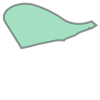

In [145]:
geo_df['Polygon'][0]

In [146]:
geo_df['City District'][0]

'Hafen'

In [147]:
#start=time.time()
#print(find_best_point_in_poly(geo_df2['Polygon'][27],3,5))
#end=time.time()
#print(end-start)

## Determining the Radius

An important quantity is the radius assigned to each station - in other words, how big is the area of influence of one station and how big is the area of influence of the new station going to be?

Assuming that each person with an electrical vehicle attends to the nearest station available is certainly a logical approach, but would lead to irregular shapes of influence. It would also mean a change in shapes for each point being tested. This would likely drive up the calculation time by quite a bit. It is therefore not a practical assumption. 

Instead, it is a more straightforward yet still reasonable approach to determine an average radius by averaging over the minimal distances to the nearest neighbor. This radius will then be assigned to the new station as well and will be used as a parameter in our functions as a uniform value for all stations.

In [148]:
chargingstations_df

Name Latitude Longitude   City District
0          Ladestation E-mobil NRW  51.2647   6.73449         Stockum
1              Parkhaus Kunsthalle  51.2273   6.77595        Altstadt
2                       Stromtanke  51.2372   6.72549          Heerdt
3   Ladesäule Stadwerke Düsseldorf  51.2226   6.81245    Flingernsued
4            Stadtwerke Düsseldorf  51.2766   6.79034       Unterrath
5            Stadtwerke Düsseldorf   51.218   6.78237  Friedrichstadt
6                              EON  51.2354   6.77466      Pempelfort
7                         Mennekes  51.2211   6.82248      Lierenfeld
8                  DB Energie GmbH  51.2211   6.79354      Stadtmitte
9            Stadtwerke Düsseldorf   51.239   6.78032      Pempelfort
10                     Parsevalstr  51.2788   6.78575       Unterrath
11           Stadtwerke Düsseldorf  51.2454   6.76943        Golzheim
12                        Aldi Süd  51.2627   6.78089       Derendorf
13           Stadtwerke Düsseldorf  51.2139   6.77703  Friedrichstadt
14           Stadtwerke Düsseldorf  51.1938   6.81292         Wersten

In [149]:
minimal_distance=[]
closest_station=[]
currentminimum=1000
for i in range(len(chargingstations_df)):
    for j in range(len(chargingstations_df)):
        currentdistance=geo_dist_km(chargingstations_df['Longitude'][i],chargingstations_df['Latitude'][i],chargingstations_df['Longitude'][j],chargingstations_df['Latitude'][j])
        if (i!=j and currentdistance<currentminimum):
            currentminimum=currentdistance
            closestindex=j
    minimal_distance.append(currentminimum) 
    closest_station.append(closestindex)
    currentminimum=1000
print(minimal_distance)
print(closest_station)

[3.1256372038260385, 0.9056345481980669, 3.1256372038260385, 0.7179389529748537, 0.3972566913203596, 0.5903204131482405, 0.5659581475866607, 0.7179389529748537, 0.8489169223524118, 0.5659581475866607, 0.3972566913203596, 1.038747258968038, 1.6832332880304501, 0.5903204131482405, 3.1050460597286182]
[2, 6, 0, 7, 10, 13, 9, 3, 5, 6, 4, 9, 4, 5, 7]


In [150]:
chargingstations_df['Next Station [km]']=minimal_distance

In [151]:
chargingstations_df.head()

Name Latitude Longitude City District  \
0         Ladestation E-mobil NRW  51.2647   6.73449       Stockum   
1             Parkhaus Kunsthalle  51.2273   6.77595      Altstadt   
2                      Stromtanke  51.2372   6.72549        Heerdt   
3  Ladesäule Stadwerke Düsseldorf  51.2226   6.81245  Flingernsued   
4           Stadtwerke Düsseldorf  51.2766   6.79034     Unterrath   

   Next Station [km]  
0           3.125637  
1           0.905635  
2           3.125637  
3           0.717939  
4           0.397257

In [152]:
radius=chargingstations_df['Next Station [km]'].mean()
radius

1.2250533929993261

This is our radius. Let's visualize the area of influence with this radius and compare it to the case with 5km. Afterwards we can determine the best spot in Düsseldorf to place the next station.

In [153]:
duesseldorf_stations_map=folium.Map(location=[duesseldorf_latitude, duesseldorf_longitude],zoom_start=12)

In [154]:
duesseldorf_stations_map

In [155]:
radius_for_map=radius
ev_stations_circles= folium.map.FeatureGroup()
for i in range(len(chargingstations_df)):
    ev_stations_circles.add_child(folium.Circle([chargingstations_df.Latitude[i], chargingstations_df.Longitude[i]], radius=radius_for_map*1000, color='red'))

In [156]:
duesseldorf_stations_map.add_child(ev_stations_circles)

In [157]:
duesseldorf_stations_map.save(outfile='results/stationswithradius.html')

now to compare with the 5km case.

In [158]:
duesseldorf_stations_5kmmap=folium.Map(location=[duesseldorf_latitude, duesseldorf_longitude],zoom_start=12)

In [159]:
duesseldorf_stations_5kmmap

In [160]:
radius_for_map=radius
ev_stations_circles2= folium.map.FeatureGroup()
for i in range(len(chargingstations_df)):
    ev_stations_circles2.add_child(folium.Circle([chargingstations_df.Latitude[i], chargingstations_df.Longitude[i]], radius=5*1000, color='red'))

In [161]:
duesseldorf_stations_5kmmap.add_child(ev_stations_circles2)

In [162]:
duesseldorf_stations_5kmmap.save(outfile='results/stationswith5kmradius.html')

## Running the Algorithm to Determine the Optimal Spot for a New Station

In [163]:
best_points=[]

In [164]:
for i in range(len(geo_df['Polygon'])):
    print('Finding optimal coordinates for district ',geo_df['City District'][i])
    best_points.append(find_best_point_in_poly(geo_df['Polygon'][i],radius,5))
print('done!')

Finding optimal coordinates for district  Hafen
6.722257 6.765742 51.208387 51.229271
15 11
Finding optimal coordinates for district  Ludenberg
6.824054 6.879068 51.238169 51.264255
19 14
Finding optimal coordinates for district  Carlstadt
6.763487 6.775664 51.21902 51.225884
4 3
Finding optimal coordinates for district  Holthausen
6.810505 6.855297 51.155856 51.190165
15 19
Finding optimal coordinates for district  Itter
6.808535 6.828833 51.145632 51.175579
7 16
Finding optimal coordinates for district  Rath
6.793545 6.867388 51.250884 51.280575
25 16
Finding optimal coordinates for district  Derendorf
6.761889 6.796209 51.242357 51.263243
11 11
Finding optimal coordinates for district  Moersenbroich
6.79184 6.822183 51.243025 51.263007
10 11
Finding optimal coordinates for district  Niederkassel
6.737774 6.768242 51.234235 51.252028
10 9
Finding optimal coordinates for district  Hassels
6.85017 6.904765 51.169958 51.190292
19 11
Finding optimal coordinates for district  Loerick
6.71

In [165]:
best_points

[([6.762843, 51.217879727272724],
  [[6.762843, 51.217879727272724]],
  2983.603603603605),
 ([6.832740421052632, 51.24189557142857],
  [[6.832740421052632, 51.24189557142857]],
  4292.504504504504),
 ([6.76653125, 51.221308], [[6.76653125, 51.221308]], 2725.0981981981977),
 ([6.8463386, 51.18835926315789],
  [[6.8463386, 51.18835926315789]],
  4186.639639639639),
 ([6.811434714285714, 51.1737073125],
  [[6.811434714285714, 51.1737073125]],
  2074.1714285714284),
 ([6.82012848, 51.2527396875],
  [[6.82012848, 51.2527396875]],
  3666.90990990991),
 ([6.793089, 51.24425572727272],
  [[6.793089, 51.24425572727272]],
  5232.957207207207),
 ([6.8130801, 51.24484154545455],
  [[6.8130801, 51.24484154545455]],
  6769.342342342342),
 ([6.7469144, 51.236212], [[6.7469144, 51.236212]], 2682.9504504504516),
 ([6.855916842105263, 51.18844345454546],
  [[6.855916842105263, 51.18844345454546]],
  3881.0810810810813),
 ([6.7431038, 51.241448], [[6.7431038, 51.241448]], 2338.244744744745),
 ([6.771019

In [166]:
best_coordinates=[]
bestavaipop=[]
for i in range(len(best_points)):
    best_coordinates.append(best_points[i][0])
    bestavaipop.append(best_points[i][2])

In [167]:
geo_df.rename(columns={'Avg. Available Population Density [1/km²]':'Available Population Density [1/km²]'} ,inplace=True)

In [168]:
geo_df['Optimal Coordinates (lon,lat)']=best_coordinates

In [169]:
geo_df['Available Population Density [1/km²]']=bestavaipop

In [170]:
geo_df.head()

City District                                           Geometry  \
0         Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1     Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2     Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3    Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4         Itter  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type Population Density [1/km^2]  \
0  <class 'geojson.feature.FeatureCollection'>                          32   
1  <class 'geojson.feature.FeatureCollection'>                        1077   
2  <class 'geojson.feature.FeatureCollection'>                        4804   
3  <class 'geojson.feature.FeatureCollection'>                        2276   
4  <class 'geojson.feature.FeatureCollection'>                         749   

                                             Polygon  \
0  POLYGON ((6.730208 51.208949, 6.729931 51.2094...   
1  POLYGON ((6.879068 51.261155, 6.878906 51.2604...   
2  POLYGON ((6.775664 51.225005, 6.775456 51.2249...   
3  POLYGON ((6.853443 51.17138, 6.853407 51.17129...   
4  POLYGON ((6.826055 51.157212, 6.823194 51.1611...   

            Optimal Coordinates (lon,lat)  \
0          [6.762843, 51.217879727272724]   
1  [6.832740421052632, 51.24189557142857]   
2                 [6.76653125, 51.221308]   
3          [6.8463386, 51.18835926315789]   
4      [6.811434714285714, 51.1737073125]   

   Available Population Density [1/km²]  
0                           2983.603604  
1                           4292.504505  
2                           2725.098198  
3                           4186.639640  
4                           2074.171429

In [171]:
geo_df['City District'][geo_df['Available Population Density [1/km²]'].idxmax()]

'Duesseltal'

In [172]:
geo_df['Optimal Coordinates (lon,lat)'][geo_df['Available Population Density [1/km²]'].idxmax()]

[6.8124720000000005, 51.241458]

In [173]:
geo_df['Available Population Density [1/km²]'][geo_df['Available Population Density [1/km²]'].idxmax()]

7265.225225225226

In [174]:
optimal_coord_station=geo_df['Optimal Coordinates (lon,lat)'][geo_df['Available Population Density [1/km²]'].idxmax()]

In [175]:
geo_df.to_csv(path_or_buf='results/geodf.csv')

In [176]:
geo_df.head()

City District                                           Geometry  \
0         Hafen  {'type': 'FeatureCollection', 'generator': 'JO...   
1     Ludenberg  {'type': 'FeatureCollection', 'generator': 'JO...   
2     Carlstadt  {'type': 'FeatureCollection', 'generator': 'JO...   
3    Holthausen  {'type': 'FeatureCollection', 'generator': 'JO...   
4         Itter  {'type': 'FeatureCollection', 'generator': 'JO...   

                                          Type Population Density [1/km^2]  \
0  <class 'geojson.feature.FeatureCollection'>                          32   
1  <class 'geojson.feature.FeatureCollection'>                        1077   
2  <class 'geojson.feature.FeatureCollection'>                        4804   
3  <class 'geojson.feature.FeatureCollection'>                        2276   
4  <class 'geojson.feature.FeatureCollection'>                         749   

                                             Polygon  \
0  POLYGON ((6.730208 51.208949, 6.729931 51.2094...   
1  POLYGON ((6.879068 51.261155, 6.878906 51.2604...   
2  POLYGON ((6.775664 51.225005, 6.775456 51.2249...   
3  POLYGON ((6.853443 51.17138, 6.853407 51.17129...   
4  POLYGON ((6.826055 51.157212, 6.823194 51.1611...   

            Optimal Coordinates (lon,lat)  \
0          [6.762843, 51.217879727272724]   
1  [6.832740421052632, 51.24189557142857]   
2                 [6.76653125, 51.221308]   
3          [6.8463386, 51.18835926315789]   
4      [6.811434714285714, 51.1737073125]   

   Available Population Density [1/km²]  
0                           2983.603604  
1                           4292.504505  
2                           2725.098198  
3                           4186.639640  
4                           2074.171429

Incidentally, here is the distance between the optimum coordinates for the case of the determined radius and the resulting coordinates for a separate run with the radius set to 5km, just to illustrate the huge difference the choice of radius can have for the outcome of the algorithm:

In [177]:
geo_dist_km(6.9220068, 51.137066,6.81247,51.241458)

13.8930728879804

The point you would get in this case would be far from the town centre, near the southern edge of the city. But now, let us illustrate the location of the proposed new station in Düsseldorf based on the result of this algorithm by showing it on our map.

## Visualisation of Result

In [178]:
new_station= folium.map.FeatureGroup()

In [179]:
type(new_station)

folium.map.FeatureGroup

In [180]:
new_station.add_child(folium.CircleMarker([optimal_coord_station[1],optimal_coord_station[0]], radius=5, color='yellow', fill_color='Yellow'))

In [181]:
duesseldorf_map.add_child(new_station)

This is our final result. The yellow circle marks the position where the new station would ideally be placed in order to attract the most customers.

In [182]:
#doesn't seem to work
#duesseldorf_map.save(outfile='results/location_of_new_station.png')

In [183]:
duesseldorf_map.save(outfile='results/location_of_new_station.html')

In [184]:
#doesn't seem to work either:
#duesseldorf_map.save(outfile='results/location_of_new_station.jpg')

In [185]:
duesseldorf_map2= folium.Map(location=[duesseldorf_latitude, duesseldorf_longitude],zoom_start=12)

In [186]:
duesseldorf_map2

In [187]:
folium.Choropleth(
    geo_data=geojson_for_choropleth,
    name='Available Population Density',
    data=geo_df,
    columns=['City District', 'Available Population Density [1/km²]'],
    fill_color='YlGn',
    fill_opacity=0.5,
    key_on='feature.id',
    legend_name='Available population per square km'
).add_to(duesseldorf_map2) 

In [188]:
duesseldorf_map2

In [189]:
duesseldorf_map2.save(outfile='results/avaipopden.html')